In [1]:
%config IPCompleter.use_jedi = False
%pdb off
%load_ext autoreload
%autoreload 3

# required to enable non-blocking interaction:
%gui qt5

import sys
from copy import deepcopy
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from neuropy.utils.result_context import IdentifyingContext
from nptyping import NDArray
import neuropy.utils.type_aliases as types
from collections import defaultdict

import numpy as np
import pandas as pd
import re
from pathlib import Path
from datetime import datetime

from neuropy.utils.indexing_helpers import PandasHelpers
from pyphocorehelpers.indexing_helpers import partition_df
# Set the maximum number of columns to display
pd.set_option('display.max_columns', 100)

import IPython
from pyphocorehelpers.programming_helpers import IPythonHelpers
from pyphocorehelpers.notebook_helpers import NotebookCellExecutionLogger
from pyphocorehelpers.assertion_helpers import Assert

# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

_notebook_path:Path = Path(IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())).resolve() # Finds the path of THIS notebook

# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')

# Switch to the desired interactivity mode
plt.interactive(True)

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
template: str = 'plotly_dark' # set plotl template
pio.templates.default = template
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard
from pyphocorehelpers.Filesystem.path_helpers import file_uri_from_path, sanitize_filename_for_Windows
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, simple_path_display_widget
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results
from pyphocorehelpers.assertion_helpers import Assert

# from ..PendingNotebookCode import plot_across_sessions_scatter_results, plot_histograms, plot_stacked_histograms
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import find_csv_files, find_HDF5_files, find_most_recent_files
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_histograms, plot_stacked_histograms

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_files, _process_and_load_exported_file, _common_cleanup_operations

from pyphocorehelpers.programming_helpers import metadata_attributes
from pyphocorehelpers.function_helpers import function_attributes

from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import build_session_t_delta, _new_process_csv_files, _old_process_csv_files

debug_print: bool = False
enable_neptune: bool = False

_TODAY_DAY_ONLY_DATE: str = "2024-09-11"
TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_Apogee"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_GL"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_Lab"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_rMBP"

print(f'TODAY_DAY_DATE: {TODAY_DAY_DATE}')

types.session_str: TypeAlias = str # a unique session identifier

if enable_neptune:
    import neptune # for logging progress and results
    from neptune.types import File
    from pyphoplacecellanalysis.General.Batch.NeptuneAiHelpers import Neptuner, AutoValueConvertingNeptuneRun, set_environment_variables 

    ## Gets the notebook filepath for Neptune:
    import IPython
    from pyphocorehelpers.programming_helpers import IPythonHelpers
    notebook_filepath: str = IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())
    assert Path(notebook_filepath).resolve().exists(), f"found notebook filepath: '{notebook_filepath}' does not exist"
    # notebook_filepath

    neptune_kwargs = {'project':"commander.pho/PhoDibaLongShortAcrossSessions",
    'api_token':"eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGIxODU2My1lZTNhLTQ2ZWMtOTkzNS02ZTRmNzM5YmNjNjIifQ=="}
            
    neptuner = Neptuner(project_name=neptune_kwargs['project'], api_token=neptune_kwargs['api_token'])


    if neptuner.run is None:
        neptuner.run = AutoValueConvertingNeptuneRun(project=neptuner.project_name, api_token=neptuner.api_token, dependencies="infer", source_files=[notebook_filepath])
        params = {"TODAY_DAY_DATE": TODAY_DAY_DATE, "run_workstation": "Apogee"}
        neptuner.run["parameters"] = params
        neptuner.outputs = neptuner.run['outputs']
        neptuner.figures = neptuner.outputs['figures']

    neptuner_run: AutoValueConvertingNeptuneRun = neptuner.run
    
    # run = neptune.init_run(source_files=["**/*.dvc"])

    # # Pre-execution dataframe view:
    # run["dataset/global_batch_run_progress_df"].upload(File.as_html(global_batch_run.to_dataframe(expand_context=True, good_only=False))) # "path/to/test_preds.csv"

else:
    # no neptune:
    neptuner = None    
    neptuner_run = None


known_bad_sessions = [IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_17-46-44')]
known_bad_session_strs = [str(v.get_description()) for v in known_bad_sessions]
known_bad_session_strs

Automatic pdb calling has been turned OFF
TODAY_DAY_DATE: 2024-09-11_Apogee


['kdiba_pin01_one_11-02_17-46-44']

### csv_files

In [2]:
## Load across session t_delta CSV, which contains the t_delta for each session:

## INPUTS: known_bad_session_strs,

# cuttoff_date = datetime(2024, 8, 29)
cuttoff_date = datetime(2024, 7, 1)
# cuttoff_date = datetime(2024, 5, 18)
# cuttoff_date = None

known_collected_outputs_paths = [Path(v).resolve() for v in ['/Users/pho/data/collected_outputs',
                                                            '/Volumes/SwapSSD/Data/collected_outputs', r"K:/scratch/collected_outputs", '/Users/pho/Dropbox (University of Michigan)/MED-DibaLabDropbox/Data/Pho/Outputs/output/collected_outputs', r'C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs',
                                                            '/home/halechr/FastData/collected_outputs/', '/home/halechr/cloud/turbo/Data/Output/collected_outputs']]
collected_outputs_directory = find_first_extant_path(known_collected_outputs_paths)
assert collected_outputs_directory.exists(), f"collected_outputs_directory: {collected_outputs_directory} does not exist! Is the right computer's config commented out above?"
# fullwidth_path_widget(scripts_output_path, file_name_label='Scripts Output Path:')
print(f'collected_outputs_directory: {collected_outputs_directory}')

# _active_folder_widget = fullwidth_path_widget(collected_outputs_directory)
# display(_active_folder_widget)

# Create a 'figures' subfolder if it doesn't exist
figures_folder: Path = collected_outputs_directory.joinpath('figures').resolve()
figures_folder.mkdir(parents=False, exist_ok=True)
assert figures_folder.exists()
print(f'\tfigures_folder: {file_uri_from_path(figures_folder)}')

# Create an output path for the across session collected results (like the aggregate CSVs built from the individual session CSVs)
across_sessions_output_folder: Path = collected_outputs_directory.joinpath('../across_sessions').resolve()
across_sessions_output_folder.mkdir(parents=False, exist_ok=True)
assert across_sessions_output_folder.exists()
print(f'\tacross_sessions_output_folder: {file_uri_from_path(across_sessions_output_folder)}')

## sessions' t_delta:
t_delta_csv_path = collected_outputs_directory.joinpath('../2024-01-18_GL_t_split_df.csv').resolve() # GL
# t_delta_csv_path = collected_outputs_directory.joinpath('2024-06-11_GL_t_split_df.csv').resolve()

t_delta_df, t_delta_dict, (earliest_delta_aligned_t_start, latest_delta_aligned_t_end) = build_session_t_delta(t_delta_csv_path=t_delta_csv_path)

if neptuner_run is not None:
    _neptuner_run_parameters = dict(cuttoff_date=cuttoff_date, collected_outputs_directory=collected_outputs_directory.as_posix(), figures_folder=figures_folder.as_posix(),
                           across_sessions_output_folder=across_sessions_output_folder.as_posix(), t_delta_csv_path=t_delta_csv_path.as_posix())
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parameters/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

## Find the files:
csv_files = find_csv_files(collected_outputs_directory)
h5_files = find_HDF5_files(collected_outputs_directory)

csv_sessions, parsed_csv_files_df  = find_most_recent_files(found_session_export_paths=csv_files, cuttoff_date=cuttoff_date)
h5_sessions, parsed_h5_files_df = find_most_recent_files(found_session_export_paths=h5_files)

## OUTPUTS: csv_files, csv_sessions, parsed_csv_files_df
## OUTPUTS: h5_files, h5_sessions, parsed_h5_files_df

_neptuner_run_parameters = dict(csv_files=csv_files, h5_files=h5_files, csv_sessions=csv_sessions, h5_sessions=h5_sessions)

# #TODO 2024-03-02 12:12: - [ ] Could add weighted correlation if there is a dataframe for that and it's computed:
_df_raw_variable_names = ['simple_pf_pearson_merged_df', 'weighted_corr_merged_df']
_df_variables_names = ['laps_weighted_corr_merged_df', 'ripple_weighted_corr_merged_df', 'laps_simple_pf_pearson_merged_df', 'ripple_simple_pf_pearson_merged_df']

# # tbin_values_dict = {'laps': self.laps_decoding_time_bin_size, 'ripple': self.ripple_decoding_time_bin_size}
time_col_name_dict = {'laps': 'lap_start_t', 'ripple': 'ripple_start_t'} ## default should be 't_bin_center'

# fold older files:
# {'laps_marginals_df': 'lap_start_t', 'ripple_marginals_df': 'ripple_start_t', 'laps_time_bin_marginals_df':'t_bin_center', 'ripple_time_bin_marginals_df':'t_bin_center'}

if neptuner_run is not None:
    _neptuner_run_parameters = _neptuner_run_parameters | dict(earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
                                     t_delta_df=t_delta_df)
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

all_session_experiment_experience_csv_path = Path("./EXTERNAL/sessions_experiment_datetime_df.csv").resolve()
Assert.path_exists(all_session_experiment_experience_csv_path)
## NEW `parsed_csv_files_df1-based approach 2024-07-11 - 
## INPUTS: parsed_csv_files_df
dict_results, df_results, excluded_or_outdated_files_list = _new_process_csv_files(parsed_csv_files_df=parsed_csv_files_df, t_delta_dict=t_delta_dict, cuttoff_date=cuttoff_date, known_bad_session_strs=known_bad_session_strs, all_session_experiment_experience_csv_path=all_session_experiment_experience_csv_path, debug_print=False) # , known_bad_session_strs=known_bad_session_strs
(final_sessions_loaded_laps_dict, final_sessions_loaded_ripple_dict, final_sessions_loaded_laps_time_bin_dict, final_sessions_loaded_ripple_time_bin_dict, final_sessions_loaded_simple_pearson_laps_dict, final_sessions_loaded_simple_pearson_ripple_dict, final_sessions_loaded_laps_wcorr_dict, final_sessions_loaded_ripple_wcorr_dict, final_sessions_loaded_laps_all_scores_dict, final_sessions_loaded_ripple_all_scores_dict) = dict_results
(all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_simple_pearson_laps_df, all_sessions_simple_pearson_ripple_df, all_sessions_wcorr_laps_df, all_sessions_wcorr_ripple_df, all_sessions_all_scores_ripple_df) = df_results

collected_outputs_directory: K:\scratch\collected_outputs
	figures_folder: file:///K:/scratch/collected_outputs/figures
	across_sessions_output_folder: file:///K:/scratch/across_sessions
earliest_delta_aligned_t_start: -2057.2259484970764, latest_delta_aligned_t_end: 1661.8560019930592
ERR: Could not parse filename: "session_h5_files_copydict_2024-09-10_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-09-11_GL"
WARN: curr_session_t_delta is None for session_str = "11-02_17-46-44"
File type merged_complete_epoch_stats_df not implemented.
WARN: curr_session_t_delta is None for session_str = "11-02_17-46-44"
File type neuron_replay_stats_df not implemented.
WARN: curr_session_t_delta is None for session_str = "11-02_19-28-0"
File type merged_complete_epoch_stats_df not implemented.
WARN: curr_session_t_delta is None for session_str = "11-02_19-28-0"
File type neuron_replay_stats_df not implemented.
WARN: curr_session_t_delta is None for session_str = "2006-4-09_16-40-54"

In [3]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_and_apply_session_experience_rank_csv

all_session_experiment_experience_csv_path = Path("./EXTERNAL/sessions_experiment_datetime_df.csv").resolve()
Assert.path_exists(all_session_experiment_experience_csv_path)
sessions_df, (experience_rank_map_dict, experience_orientation_rank_map_dict), _callback_add_df_columns = load_and_apply_session_experience_rank_csv(all_session_experiment_experience_csv_path, session_uid_str_sep='_')
df_results = [_callback_add_df_columns(a_df, session_id_column_name='session_name') for a_df in df_results]
all_sessions_all_scores_ripple_df = _callback_add_df_columns(all_sessions_all_scores_ripple_df, session_id_column_name='session_name')


# all_sessions_all_scores_ripple_df
# all_sessions_all_scores_ripple_df['session_name']

In [4]:
all_sessions_all_scores_ripple_df
# all_sessions_ripple_time_bin_df

start         stop  label  duration is_valid_epoch      P_LR  \
0        19.584635    19.710587      1  0.125952           True  0.509376   
1        28.343394    28.453003      2  0.109609           True  0.554285   
2        57.231484    57.443913      3  0.212429          False  0.379173   
3        80.191232    80.587704      4  0.396472           True  0.394597   
4        81.141524    81.427926      5  0.286402           True  0.387113   
...            ...          ...    ...       ...            ...       ...   
36842  1417.968979  1418.282814    192  0.313835            NaN  0.028922   
36843  1429.924337  1430.429558    193  0.505221            NaN  0.403429   
36844  1435.942904  1436.334707    196  0.391803            NaN  0.644754   
36845  1445.197729  1445.522931    200  0.325202            NaN  0.999331   
36846  1456.458569  1456.886960    203  0.428390            NaN  0.792173   

           P_RL    P_Long   P_Short  P_Long_LR  \
0      0.490624  0.861733  0.138267   0.438946   
1      0.445715  0.880086  0.119914   0.487819   
2      0.620827  0.479174  0.520826   0.181690   
3      0.605403  0.812257  0.187743   0.320514   
4      0.612887  0.819695  0.180305   0.317315   
...         ...       ...       ...        ...   
36842  0.971078  0.877494  0.122506   0.025379   
36843  0.596571  0.229620  0.770380   0.092635   
36844  0.355246  0.000172  0.999828   0.000111   
36845  0.000669  0.719878  0.280122   0.719397   
36846  0.207827  0.058027  0.941973   0.045967   

       congruent_dir_bins_ratio_long_LR  coverage_long_LR  \
0                              0.500000          0.245614   
1                              0.400000          0.263158   
2                              0.166667          0.614035   
3                              0.347826          0.210526   
4                              0.375000          0.175439   
...                                 ...               ...   
36842                               NaN               NaN   
36843                               NaN               NaN   
36844                               NaN               NaN   
36845                               NaN               NaN   
36846                               NaN               NaN   

       direction_change_bin_ratio_long_LR  integral_second_derivative_long_LR  \
0                                0.500000                       117853.583616   
1                                0.400000                        73505.146015   
2                                0.166667                        88240.410100   
3                                0.521739                       591393.333714   
4                                0.562500                       388551.653852   
...                                   ...                                 ...   
36842                                 NaN                                 NaN   
36843                                 NaN                                 NaN   
36844                                 NaN                                 NaN   
36845                                 NaN                                 NaN   
36846                                 NaN                                 NaN   

       jump_long_LR  longest_sequence_length_ratio_long_LR  pearsonr_long_LR  \
0          0.003087                               0.571429               NaN   
1          0.003171                               0.666667         -0.038696   
2          0.003421                               0.846154         -0.573668   
3          0.003171                               0.208333         -0.796396   
4          0.003087                               0.235294         -0.609459   
...             ...                                    ...               ...   
36842           NaN                                    NaN         -0.089592   
36843           NaN                                    NaN          0.539372   
36844           NaN                                    NaN   

# h5_files

In [5]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_h5_files

## INPUTS: h5_sessions, session_dict, cuttoff_date, known_bad_session_strs
parsed_h5_files_df, h5_contexts_paths_dict = load_across_sessions_exported_h5_files(collected_outputs_directory=collected_outputs_directory, cuttoff_date=cuttoff_date,
                                                                                    known_bad_session_strs=known_bad_session_strs)
h5_session_contexts = list(h5_contexts_paths_dict.keys())
included_h5_paths = list(h5_contexts_paths_dict.values())

if neptuner_run is not None:
    _neptuner_run_parameters = dict(parsed_h5_files_df=parsed_h5_files_df,
                                       )
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

parsed_h5_files_df
# h5_contexts_paths_dict


collected_outputs_directory: K:\scratch\collected_outputs


export_datetime                                            session  \
2        2024-09-11                                     11-02_17-46-44   
5        2024-09-11                                     11-02_17-46-44   
8        2024-09-11                                      11-02_19-28-0   
11       2024-09-11                                      11-02_19-28-0   
14       2024-09-11                                      11-03_12-3-25   
17       2024-09-11                                 2006-4-09_16-40-54   
20       2024-09-11                                 2006-4-09_16-40-54   
23       2024-09-11                                 2006-4-09_17-29-30   
26       2024-09-11                                 2006-4-09_17-29-30   
29       2024-09-11                                 2006-4-10_12-25-50   
32       2024-09-11                                 2006-4-10_12-25-50   
35       2024-09-11                                  2006-4-10_12-58-3   
38       2024-09-11                                  2006-4-10_12-58-3   
40       2024-09-11                                 2006-6-07_11-26-53   
41       2024-09-11                            2006-6-07_11-26-53-None   
44       2024-09-11                                 2006-6-07_16-40-19   
47       2024-09-11                                 2006-6-07_16-40-19   
50       2024-09-11                                 2006-6-08_14-26-15   
54       2024-09-11                                 2006-6-08_14-26-15   
55       2024-08-29                            2006-6-08_14-26-15-None   
58       2024-09-11                                 2006-6-08_21-16-25   
61       2024-09-11                                 2006-6-08_21-16-25   
64       2024-09-11                                  2006-6-09_1-22-43   
68       2024-09-11                                  2006-6-09_1-22-43   
71       2024-09-11                                 2006-6-09_22-24-40   
74       2024-09-11                                 2006-6-09_22-24-40   
77       2024-09-11                                 2006-6-12_15-55-31   
78       2024-09-04                                 2006-6-12_15-55-31   
81       2024-09-11                                 2006-6-12_16-53-46   
83       2024-09-11                                 2006-6-12_16-53-46   
86       2024-09-11                                  fet11-01_12-58-54   
89       2024-09-11                                  fet11-01_12-58-54   
91       2024-09-03                                            session   
92       2024-09-04  withNewComputedReplays-qclu_[1, 2]-frateThresh...   
93       2024-09-04  withNewComputedReplays-qclu_[1, 2]-frateThresh...   
94       2024-09-04  withNewComputedReplays-qclu_[1, 2]-frateThresh...   
95       2024-09-04  withNewKamranExportedReplays-qclu_[1,2]-frateT...   
96       2024-09-04  withNewKamranExportedReplays-qclu_[1,2]-frateT...   
97       2024-09-04  withNewKamranExportedReplays-qclu_[1,2]-frateT...   
98       2024-09-04  withNormalComputedReplays-qclu_[1,2]-frateThre...   
99       2024-09-04  withNormalComputedReplays-qclu_[1,2]-frateThre...   
100      2024-09-04  withNormalComputedReplays-qclu_[1,2]-frateThre...   
101      2024-09-04                     withOldestImportedReplays-qclu   

    custom_replay_name                     file_type  \
2                                   pipeline_results   
5                        time_bin_size_sweep_results   
8                                   pipeline_results   
11                       time_bin_size_sweep_results   
14                                  pipeline_results   
17                                  pipeline_results   
20                       time_bin_size_sweep_results   
23                                  pipeline_results   
26                       time_bin_size_sweep_results   
29                                  pipeline_results   
32                       time_bin_size_sweep_results   
35                                  pipeline_results   
38                 

In [6]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative

included_session_contexts = deepcopy(h5_session_contexts)
included_h5_paths = deepcopy(included_h5_paths)
num_sessions = len(included_session_contexts)
(neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table), output_path_dicts = AcrossSessionTables.build_and_save_all_combined_tables(included_session_contexts, included_h5_paths,
                                                                                                                                                    override_output_parent_path=across_sessions_output_folder, output_path_suffix=f'{TODAY_DAY_DATE}',
                                                                                                                                                    should_restore_native_column_types=True, include_csv=True, include_pkl=True)


if neptuner_run is not None:
    _neptuner_run_parameters = dict(neuron_identities_table=neuron_identities_table, long_short_fr_indicies_analysis_table=long_short_fr_indicies_analysis_table, neuron_replay_stats_table=neuron_replay_stats_table,
                                       num_sessions=num_sessions)
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

    for output_name, a_paths_dict in output_path_dicts.items():
        for format_extension, an_output_path in a_paths_dict.items():
            neptuner_run[f"output_files/{format_extension}/{output_name}"].upload(an_output_path.resolve().as_posix())


# {'neuron_identities_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_identities_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_identities_table.pkl')},
#  'long_short_fr_indicies_analysis_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/long_short_fr_indicies_analysis_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/long_short_fr_indicies_analysis_table.pkl')},
#  'neuron_replay_stats_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_replay_stats_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_replay_stats_table.pkl')}}

output_path_dicts

## Move the "height" columns to the end
neuron_replay_stats_table = reorder_columns_relative(neuron_replay_stats_table, column_names=['neuron_uid', 'format_name', 'animal', 'exper_name', 'session_name', 'neuron_type', 'aclu', 'session_uid', 'session_datetime'], relative_mode='start')

neuron_replay_stats_table


failed for file path: K:\scratch\collected_outputs\2024-09-11_GL_2006-6-12_15-55-31_pipeline_results.h5, table_key: /kdiba/gor01/one/2006-6-12_15-55-31/neuron_identities/table. wth exception group ``/`` does not have a child named ``/kdiba/gor01/one/2006-6-12_15-55-31/neuron_identities/table``. Skipping.
failed for file path: K:\scratch\collected_outputs\2024-09-11_GL_11-03_12-3-25_pipeline_results.h5, table_key: /kdiba/pin01/one/11-03_12-3-25/neuron_identities/table. wth exception group ``/`` does not have a child named ``/kdiba/pin01/one/11-03_12-3-25/neuron_identities/table``. Skipping.
concatenating dataframes from 13 of 15 files
failed for file path: K:\scratch\collected_outputs\2024-09-11_GL_2006-6-12_15-55-31_pipeline_results.h5, table_key: /kdiba/gor01/one/2006-6-12_15-55-31/global_computations/long_short_fr_indicies_analysis/table. wth exception group ``/`` does not have a child named ``/kdiba/gor01/one/2006-6-12_15-55-31/global_computations/long_short_fr_indicies_analysis/tab

{'neuron_identities_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee/neuron_identities_table.csv'),
  '.pkl': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee/neuron_identities_table.pkl')},
 'long_short_fr_indicies_analysis_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee/long_short_fr_indicies_analysis_table.csv'),
  '.pkl': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee/long_short_fr_indicies_analysis_table.pkl')},
 'neuron_replay_stats_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee/neuron_replay_stats_table.csv'),
  '.pkl': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee/neuron_replay_stats_table.pkl')}}

neuron_uid format_name animal exper_name  \
0    kdiba|gor01|one|2006-6-08_14-26-15|2       kdiba  gor01        one   
1    kdiba|gor01|one|2006-6-08_14-26-15|3       kdiba  gor01        one   
2    kdiba|gor01|one|2006-6-08_14-26-15|4       kdiba  gor01        one   
3    kdiba|gor01|one|2006-6-08_14-26-15|5       kdiba  gor01        one   
4    kdiba|gor01|one|2006-6-08_14-26-15|6       kdiba  gor01        one   
..                                    ...         ...    ...        ...   
801  kdiba|pin01|one|fet11-01_12-58-54|28       kdiba  pin01        one   
802  kdiba|pin01|one|fet11-01_12-58-54|29       kdiba  pin01        one   
803  kdiba|pin01|one|fet11-01_12-58-54|30       kdiba  pin01        one   
804  kdiba|pin01|one|fet11-01_12-58-54|31       kdiba  pin01        one   
805  kdiba|pin01|one|fet11-01_12-58-54|32       kdiba  pin01        one   

           session_name neuron_type  aclu                         session_uid  \
0    2006-6-08_14-26-15           0     2  kdiba|gor01|one|2006-6-08_14-26-15   
1    2006-6-08_14-26-15           0     3  kdiba|gor01|one|2006-6-08_14-26-15   
2    2006-6-08_14-26-15           0     4  kdiba|gor01|one|2006-6-08_14-26-15   
3    2006-6-08_14-26-15           0     5  kdiba|gor01|one|2006-6-08_14-26-15   
4    2006-6-08_14-26-15           2     6  kdiba|gor01|one|2006-6-08_14-26-15   
..                  ...         ...   ...                                 ...   
801   fet11-01_12-58-54         pyr    28   kdiba|pin01|one|fet11-01_12-58-54   
802   fet11-01_12-58-54         pyr    29   kdiba|pin01|one|fet11-01_12-58-54   
803   fet11-01_12-58-54         pyr    30   kdiba|pin01|one|fet11-01_12-58-54   
804   fet11-01_12-58-54         pyr    31   kdiba|pin01|one|fet11-01_12-58-54   
805   fet11-01_12-58-54         pyr    32   kdiba|pin01|one|fet11-01_12-58-54   

       session_datetime  long_pf_peak_x  short_pf_peak_x track_membership  \
0   2006-06-08 14:26:15             NaN              NaN                1   
1   2006-06-08 14:26:15      141.385524       198.280871                1   
2   2006-06-08 14:26:15             NaN       179.315755                2   
3   2006-06-08 14:26:15       99.662271       202.073894                1   
4   2006-06-08 14:26:15             NaN              NaN                1   
..                  ...             ...              ...              ...   
801 2009-11-01 12:58:54      180.571251       176.844138           SHARED   
802 2009-11-01 12:58:54       57.576513       102.301872           SHARED   
803 2009-11-01 12:58:54      120.937439       128.391665           SHARED   
804 2009-11-01 12:58:54      236.477951              NaN        LEFT_ONLY   
805 2009-11-01 12:58:54       98.574759        98.574759           SHARED   

     long_non_replay_mean short_non_replay_mean       non_replay_diff  \
0                0.412424              0.115533             -0.296891   
1                0.274069              1.394595              1.120526   
2                0.119382              0.924896              0.805514   
3                2.326046              2.012612             -0.313434   
4               25.389639             12.754636            -12.635004   
..                    ...                   ...                   ...   
801              1.227517    1.3169564137781686   0.08943915035797345   
802              0.929991    0.8388929037677681   -0.0910981891459075   
803              0.952187    0.8423839925259716  -0.10980286376952897   
804              1.156581     1.026152466402774  -0.13042850200623213   
805              1.447410    0.4548596984504662   -0.9925506842556182   

       long_replay_mean  short_replay_mean           replay_diff  \
0               7.91274                NaN                   NaN   
1              9.241991           8.536258             -0.705733   
2                   NaN          12.484801                   NaN   
3             11.994904          11.315249             -0.679655   
4            10

In [11]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults

# output_path_suffix: str = f'2024-09-11_GL'
output_path_suffix: str = f'2024-09-12'
inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}.pkl'
across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=collected_outputs_directory, inst_fr_output_filename=inst_fr_output_filename)
# across_sessions_instantaneous_fr_dict = loadData(global_batch_result_inst_fr_file_path)
num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')


global_batch_result_inst_fr_file_path: K:\scratch\collected_outputs\across_session_result_long_short_recomputed_inst_firing_rate_2024-09-12.pkl
Computing loaded session pickle file results : "K:/scratch/collected_outputs/across_session_result_long_short_recomputed_inst_firing_rate_2024-09-12.pkl"... done.
num_sessions: 13
num_sessions: 13


In [12]:
across_session_inst_fr_computation

InstantaneousSpikeRateGroupsComputation(instantaneous_time_bin_size_seconds=0.01, active_identifying_session_ctx=IdentifyingContext<('kdiba', 13)>, LxC_aclus=array(['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91',
       'a0s4_95', 'a0s5_38', 'a0s5_59', 'a1s1_23', 'a1s2_25', 'a1s3_14',
       'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27'], dtype='<U32'), SxC_aclus=array(['a0s0_23', 'a0s0_4', 'a0s0_58', 'a0s1_55', 'a0s2_3', 'a0s2_19',
       'a0s3_8', 'a0s5_8', 'a1s0_41', 'a1s1_29', 'a2s0_17'], dtype='<U32'), Fig2_Replay_FR=[SingleBarResult(mean=1.4940262607698784, std=1.0698624645244517, values=array([0.38000416, 1.62111344, 1.54731936, 2.32263415, 0.5556715 ,
       1.56555207, 3.65829217, 0.        , 1.0019871 , 1.91516326,
       0.65361032, 3.5310506 , 1.81648137, 2.2919923 , 2.09351438,
       0.44406025, 0.        ]), LxC_aclus=array(['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91',
       'a0s4_95', 'a0s5_38', 'a0s5_59', 'a1s1_23', 'a1s

In [13]:
across_sessions_instantaneous_frs_list

[InstantaneousSpikeRateGroupsComputation(instantaneous_time_bin_size_seconds=0.0005, active_identifying_session_ctx=IdentifyingContext<('kdiba', 'gor01', 'one', '2006-6-08_14-26-15')>, LxC_aclus=[109], SxC_aclus=[23, 4, 58], Fig2_Replay_FR=[SingleBarResult(mean=0.3800041597034557, std=0.0, values=array([0.38000416]), LxC_aclus=[109], SxC_aclus=[23, 4, 58], LxC_scatter_props=None, SxC_scatter_props=None), SingleBarResult(mean=0.14944828136764277, std=0.0, values=array([0.14944828]), LxC_aclus=[109], SxC_aclus=[23, 4, 58], LxC_scatter_props=None, SxC_scatter_props=None), SingleBarResult(mean=0.2234109538441842, std=0.17736177293154318, values=array([0.23636696, 0.        , 0.4338659 ]), LxC_aclus=[109], SxC_aclus=[23, 4, 58], LxC_scatter_props=None, SxC_scatter_props=None), SingleBarResult(mean=2.7818772018105697, std=1.4519106670397375, values=array([0.83838562, 4.32738011, 3.17986588]), LxC_aclus=[109], SxC_aclus=[23, 4, 58], LxC_scatter_props=None, SxC_scatter_props=None)], Fig2_Laps_

In [15]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults

# matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# output_path_suffix: str = f'{TODAY_DAY_DATE}'
# output_path_suffix: str = f'2024-09-11_GL'
output_path_suffix: str = f'2024-09-12'
print(F'output_path_suffix: {output_path_suffix}')
AcrossSessionsResults.post_compute_all_sessions_processing(global_data_root_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix, plotting_enabled=False)

output_path_suffix: 2024-09-12
global_batch_result_inst_fr_file_path: K:\scratch\collected_outputs\across_session_result_long_short_recomputed_inst_firing_rate_2024-09-12.pkl
Computing loaded session pickle file results : "K:/scratch/collected_outputs/across_session_result_long_short_recomputed_inst_firing_rate_2024-09-12.pkl"... done.
num_sessions: 13
num_sessions: 13
a_name: neuron_identities_table
loading K:\scratch\collected_outputs\2024-09-12\neuron_identities_table.pkl.
Computing loaded session pickle file results : "K:/scratch/collected_outputs/2024-09-12/neuron_identities_table.pkl"... done.
a_name: long_short_fr_indicies_analysis_table
loading K:\scratch\collected_outputs\2024-09-12\long_short_fr_indicies_analysis_table.pkl.
Computing loaded session pickle file results : "K:/scratch/collected_outputs/2024-09-12/long_short_fr_indicies_analysis_table.pkl"... done.
a_name: neuron_replay_stats_table
loading K:\scratch\collected_outputs\2024-09-12\neuron_replay_stats_table.pkl.
Com

{}

# Get filtered for a particular type of replay:

In [16]:
## filter by specific set of replays:
# dfs_list = (all_sessions_ripple_df, all_sessions_ripple_time_bin_df, all_sessions_simple_pearson_ripple_df, all_sessions_wcorr_ripple_df, all_sessions_all_scores_ripple_df)

replay_name: str = ''
# replay_name: str = 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0' # 4307 rows
# replay_name: str = 'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0' # 1417 rows, 1437 rows
# replay_name: str = 'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0' # 2802 rows, 2831 rows

time_bin_size: float = 0.025
# time_bin_size: float = 0.02
# time_bin_size: float = 0.01
filtered_all_sessions_ripple_df = deepcopy(all_sessions_ripple_df)[(all_sessions_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_ripple_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_ripple_time_bin_df = deepcopy(all_sessions_ripple_time_bin_df)[(all_sessions_ripple_time_bin_df['custom_replay_name'] == replay_name) & (all_sessions_ripple_time_bin_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_simple_pearson_ripple_df = deepcopy(all_sessions_simple_pearson_ripple_df)[(all_sessions_simple_pearson_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_simple_pearson_ripple_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_wcorr_ripple_df = deepcopy(all_sessions_wcorr_ripple_df)[(all_sessions_wcorr_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_wcorr_ripple_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_all_scores_ripple_df = deepcopy(all_sessions_all_scores_ripple_df)[(all_sessions_all_scores_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_all_scores_ripple_df['time_bin_size'] == time_bin_size)]
## OUTPUTS: filtered_all_sessions_ripple_df, filtered_all_sessions_ripple_time_bin_df, filtered_all_sessions_simple_pearson_ripple_df, filtered_all_sessions_wcorr_ripple_df, filtered_all_sessions_all_scores_ripple_df
# filtered_all_sessions_simple_pearson_ripple_df
filtered_all_sessions_all_scores_ripple_df


start         stop  label  duration is_valid_epoch      P_LR  \
0        19.584635    19.710587      1  0.125952           True  0.509376   
1        28.343394    28.453003      2  0.109609           True  0.554285   
2        57.231484    57.443913      3  0.212429          False  0.379173   
3        80.191232    80.587704      4  0.396472           True  0.394597   
4        81.141524    81.427926      5  0.286402           True  0.387113   
...            ...          ...    ...       ...            ...       ...   
36412  1429.924337  1430.429558    193  0.505221           True  0.534431   
36413  1435.942904  1436.334707    196  0.391803           True  0.472420   
36414  1437.783184  1437.959609    197  0.176425           True  0.690480   
36415  1445.197729  1445.522931    200  0.325202           True  0.668811   
36416  1456.458569  1456.886960    203  0.428390           True  0.742280   

           P_RL    P_Long   P_Short  P_Long_LR  \
0      0.490624  0.861733  0.138267   0.438946   
1      0.445715  0.880086  0.119914   0.487819   
2      0.620827  0.479174  0.520826   0.181690   
3      0.605403  0.812257  0.187743   0.320514   
4      0.612887  0.819695  0.180305   0.317315   
...         ...       ...       ...        ...   
36412  0.465569  0.383556  0.616444   0.204984   
36413  0.527580  0.375959  0.624041   0.177611   
36414  0.309520  0.522323  0.477677   0.360654   
36415  0.331189  0.562541  0.437459   0.376234   
36416  0.257720  0.450131  0.549869   0.334124   

       congruent_dir_bins_ratio_long_LR  coverage_long_LR  \
0                              0.500000          0.245614   
1                              0.400000          0.263158   
2                              0.166667          0.614035   
3                              0.347826          0.210526   
4                              0.375000          0.175439   
...                                 ...               ...   
36412                          0.368421          0.220339   
36413                          0.428571          0.474576   
36414                          0.666667          0.322034   
36415                          0.250000          0.440678   
36416                          0.500000          0.271186   

       direction_change_bin_ratio_long_LR  integral_second_derivative_long_LR  \
0                                0.500000                       117853.583616   
1                                0.400000                        73505.146015   
2                                0.166667                        88240.410100   
3                                0.521739                       591393.333714   
4                                0.562500                       388551.653852   
...                                   ...                                 ...   
36412                            0.315789                         7643.803243   
36413                            0.785714                       566296.241314   
36414                            0.333333                        99195.719359   
36415                            0.333333                        33221.144864   
36416                            0.562500                       240646.169233   

       jump_long_LR  longest_sequence_length_ratio_long_LR  pearsonr_long_LR  \
0          0.003087                               0.571429               NaN   
1          0.003171                               0.666667         -0.038696   
2          0.003421                               0.846154         -0.573668   
3          0.003171                               0.208333         -0.796396   
4          0.003087                               0.235294         -0.609459   
...             ...                                    ...               ...   
36412      0.000645                               0.350000               NaN   
36413      0.003948                               0.200000         -0.384258   
36414      0.003062                               0.428571   

## Session Enumerations

In [17]:
dataframes = {
    'all_sessions_ripple_df': all_sessions_ripple_df,
    'all_sessions_ripple_time_bin_df': all_sessions_ripple_time_bin_df,
    'all_sessions_simple_pearson_ripple_df': all_sessions_simple_pearson_ripple_df,
    'all_sessions_wcorr_ripple_df': all_sessions_wcorr_ripple_df,
    'all_sessions_all_scores_ripple_df': all_sessions_all_scores_ripple_df
}

for name, df in dataframes.items():
    unique_time_bin_counts = df.groupby('custom_replay_name')['time_bin_size'].nunique()
    print(f"== '{name}':")
    print(unique_time_bin_counts)


== 'all_sessions_ripple_df':
custom_replay_name
                                                           1
withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0         0
withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0    0
withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0       0
withOldestImportedReplays-qclu_XX-frateThresh_0.1          0
Name: time_bin_size, dtype: int64
== 'all_sessions_ripple_time_bin_df':
custom_replay_name
                                                           1
withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0         0
withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0    0
withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0       0
withOldestImportedReplays-qclu_XX-frateThresh_0.1          0
Name: time_bin_size, dtype: int64
== 'all_sessions_simple_pearson_ripple_df':
custom_replay_name
                                                           8
withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0         2
withNewKamranExportedReplays-qcl

In [18]:
all_sessions_ripple_df['custom_replay_name'].unique()
all_sessions_ripple_time_bin_df['custom_replay_name'].unique()
all_sessions_simple_pearson_ripple_df['custom_replay_name'].unique()
all_sessions_all_scores_ripple_df['custom_replay_name'].unique() 

# ['', 'withOldestImportedReplays-qclu_XX-frateThresh_0.1',
# 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0',
# 'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0',
# 'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0']


all_sessions_all_scores_ripple_df['custom_replay_name'].unique() ## OH no, only this one is missing values

array(['', 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0',
       'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0',
       'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0',
       'withOldestImportedReplays-qclu_XX-frateThresh_0.1'], dtype=object)

array(['', 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0',
       'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0',
       'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0',
       'withOldestImportedReplays-qclu_XX-frateThresh_0.1'], dtype=object)

array(['', 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0',
       'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0',
       'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0',
       'withOldestImportedReplays-qclu_XX-frateThresh_0.1'], dtype=object)

array(['', 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0',
       'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0',
       'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0',
       'withOldestImportedReplays-qclu_XX-frateThresh_0.1'], dtype=object)

array(['', 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0',
       'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0',
       'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0',
       'withOldestImportedReplays-qclu_XX-frateThresh_0.1'], dtype=object)

In [ ]:
all_sessions_ripple_df

In [ ]:
# sess_names, replay_names = all_sessions_ripple_df['session_name'].str.split('__') # , maxsplit=1

for a_split in all_sessions_ripple_df['session_name'].str.split('__'):
	print(f'a_split: {a_split}')

	if len(a_split) > 1:
		print(f'a_split: {a_split}')


In [ ]:
all_sessions_ripple_time_bin_df['custom_replay_name'].unique()
# all_sessions_ripple_df['custom_replay_name'].unique()

In [ ]:
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.show_dimensions', True)

with pd.option_context('display.min_rows', 50, 'display.show_dimensions', True):
    # max_elements
    display(parsed_csv_files_df)

# parsed_csv_files_df[parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df']


In [ ]:
parsed_csv_files_df[parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df']

# all_sessions_all_scores_ripple_df


In [ ]:
all_sessions_ripple_time_bin_df

In [ ]:
print(list(np.unique(parsed_csv_files_df.file_type))) # ['laps_marginals_df', 'laps_simple_pf_pearson_merged_df', 'laps_time_bin_marginals_df', 'laps_weighted_corr_merged_df', 'merged_complete_epoch_stats_df', 'ripple_all_scores_merged_df', 'ripple_marginals_df', 'ripple_simple_pf_pearson_merged_df', 'ripple_time_bin_marginals_df', 'ripple_weighted_corr_merged_df']

# Across Session CSV Outputs

In [19]:
display(parsed_csv_files_df)

across_sessions_parsed_csv_files_path = across_sessions_output_folder.joinpath(f'{TODAY_DAY_DATE}_parsed_csv_files_df.csv').resolve()
# parsed_csv_files_df.to_clipboard(excel=True)
parsed_csv_files_df.to_csv(across_sessions_parsed_csv_files_path)
display(fullwidth_path_widget(across_sessions_parsed_csv_files_path, file_name_label='across_sessions_parsed_csv_files_path:'))

export_datetime                            session  \
0    2024-08-30 00:00:00                     11-02_17-46-44   
2    2024-09-10 00:00:00                     11-02_17-46-44   
3    2024-08-30 00:00:00                      11-02_19-28-0   
5    2024-09-10 00:00:00                      11-02_19-28-0   
6    2024-08-30 00:00:00                 2006-4-09_16-40-54   
...                  ...                                ...   
2700 2024-09-11 14:50:00  kdiba_vvp01_two_2006-4-10_12-58-3   
2702 2024-09-11 14:50:00  kdiba_vvp01_two_2006-4-10_12-58-3   
2704 2024-09-11 14:50:00  kdiba_vvp01_two_2006-4-10_12-58-3   
2706 2024-09-11 14:50:00  kdiba_vvp01_two_2006-4-10_12-58-3   
2707 2024-09-11 00:00:00                                  t   

     custom_replay_name                       file_type  \
0                        merged_complete_epoch_stats_df   
2                                neuron_replay_stats_df   
3                        merged_complete_epoch_stats_df   
5                                neuron_replay_stats_df   
6                        merged_complete_epoch_stats_df   
...                 ...                             ...   
2700                     ripple_weighted_corr_merged_df   
2702                     ripple_weighted_corr_merged_df   
2704                     ripple_weighted_corr_merged_df   
2706                     ripple_weighted_corr_merged_df   
2707                                           split_df   

     decoding_time_bin_size_str  \
0                                 
2                                 
3                                 
5                                 
6                                 
...                         ...   
2700                      0.058   
2702                      0.072   
2704                      0.086   
2706                        0.1   
2707                              

                                                   path  
0     K:\scratch\collected_outputs\2024-08-30_GL-11-...  
2     K:\scratch\collected_outputs\2024-09-10_GL-11-...  
3     K:\scratch\collected_outputs\2024-08-30_GL-11-...  
5     K:\scratch\collected_outputs\2024-09-10_GL-11-...  
6     K:\scratch\collected_outputs\2024-08-30_GL-200...  
...                                                 ...  
2700  K:\scratch\collected_outputs\2024-09-11_0250PM...  
2702  K:\scratch\collected_outputs\2024-09-11_0250PM...  
2704  K:\scratch\collected_outputs\2024-09-11_0250PM...  
2706  K:\scratch\collected_outputs\2024-09-11_0250PM...  
2707  K:\scratch\collected_outputs\2024-09-11_GL_t_s...  

[848 rows x 6 columns]

Box(children=(Label(value='across_sessions_parsed_csv_files_path:', layout=Layout(width='auto')), HTML(value="…

In [20]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import export_across_session_CSVs

final_across_session_summary_CSVs_output_path = across_sessions_output_folder.resolve()
display(fullwidth_path_widget(final_across_session_summary_CSVs_output_path, file_name_label='final_across_session_summary_CSVs_output_path:'))
final_csv_export_paths = export_across_session_CSVs(final_output_path=final_across_session_summary_CSVs_output_path, TODAY_DAY_DATE=TODAY_DAY_DATE,
                                                    all_sessions_laps_df=all_sessions_laps_df,  all_sessions_ripple_df=all_sessions_ripple_df,  all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df,  all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df, 
                                                    all_sessions_simple_pearson_laps_df=all_sessions_simple_pearson_laps_df,  all_sessions_simple_pearson_ripple_df=all_sessions_simple_pearson_ripple_df,
                                                    all_sessions_all_scores_ripple_df=all_sessions_all_scores_ripple_df,  all_sessions_all_scores_laps_df=None,
                                                )

# final_csv_export_paths: {'AcrossSession_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Laps_per-Epoch.csv'),
#  'AcrossSession_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Ripple_per-Epoch.csv'),
#  'AcrossSession_Laps_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Laps_per-TimeBin.csv'),
#  'AcrossSession_Ripple_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Ripple_per-TimeBin.csv'),
#  'AcrossSession_SimplePearson_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_SimplePearson_Laps_per-Epoch.csv'),
#  'AcrossSession_SimplePearson_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_SimplePearson_Ripple_per-Epoch.csv'),
#  'AcrossSession_AllScores_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_AllScores_Ripple_per-Epoch.csv')}

if neptuner_run is not None:
    _neptuner_run_parameters = dict(across_sessions_parsed_csv_files_path=across_sessions_parsed_csv_files_path.as_posix(), final_across_session_summary_CSVs_output_path=final_across_session_summary_CSVs_output_path.as_posix(),
                                       )
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'output_files/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

    for k, v in final_csv_export_paths.items():
        neptuner_run[f"output_files/{k}"].upload(v.resolve().as_posix())
        
    neptuner_run.sync()
    
final_csv_export_paths

Box(children=(Label(value='final_across_session_summary_CSVs_output_path:', layout=Layout(width='auto')), HTML…

{'AcrossSession_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee_AcrossSession_Laps_per-Epoch.csv'),
 'AcrossSession_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee_AcrossSession_Ripple_per-Epoch.csv'),
 'AcrossSession_Laps_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee_AcrossSession_Laps_per-TimeBin.csv'),
 'AcrossSession_Ripple_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee_AcrossSession_Ripple_per-TimeBin.csv'),
 'AcrossSession_SimplePearson_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee_AcrossSession_SimplePearson_Laps_per-Epoch.csv'),
 'AcrossSession_SimplePearson_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee_AcrossSession_SimplePearson_Ripple_per-Epoch.csv'),
 'AcrossSession_AllScores_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-09-11_Apogee_AcrossSession_AllScores_Ripple_per-Epoch.csv')}

In [22]:
print(list(all_sessions_all_scores_ripple_df.columns)) # ['start', 'stop', 'label', 'duration', 'is_user_annotated_epoch', 'is_valid_epoch', 'P_LR', 'P_RL', 'P_Long', 'P_Short', 'P_Long_LR', 'score_long_LR', 'velocity_long_LR', 'intercept_long_LR', 'speed_long_LR', 'wcorr_long_LR', 'pearsonr_long_LR', 'travel_long_LR', 'coverage_long_LR', 'jump_long_LR', 'longest_sequence_length_ratio_long_LR', 'direction_change_bin_ratio_long_LR', 'congruent_dir_bins_ratio_long_LR', 'total_congruent_direction_change_long_LR', 'P_Long_RL', 'score_long_RL', 'velocity_long_RL', 'intercept_long_RL', 'speed_long_RL', 'wcorr_long_RL', 'pearsonr_long_RL', 'travel_long_RL', 'coverage_long_RL', 'jump_long_RL', 'longest_sequence_length_ratio_long_RL', 'direction_change_bin_ratio_long_RL', 'congruent_dir_bins_ratio_long_RL', 'total_congruent_direction_change_long_RL', 'P_Short_LR', 'score_short_LR', 'velocity_short_LR', 'intercept_short_LR', 'speed_short_LR', 'wcorr_short_LR', 'pearsonr_short_LR', 'travel_short_LR', 'coverage_short_LR', 'jump_short_LR', 'longest_sequence_length_ratio_short_LR', 'direction_change_bin_ratio_short_LR', 'congruent_dir_bins_ratio_short_LR', 'total_congruent_direction_change_short_LR', 'P_Short_RL', 'score_short_RL', 'velocity_short_RL', 'intercept_short_RL', 'speed_short_RL', 'wcorr_short_RL', 'pearsonr_short_RL', 'travel_short_RL', 'coverage_short_RL', 'jump_short_RL', 'longest_sequence_length_ratio_short_RL', 'direction_change_bin_ratio_short_RL', 'congruent_dir_bins_ratio_short_RL', 'total_congruent_direction_change_short_RL', 'ripple_start_t', 'long_best_travel', 'short_best_travel', 'travel_diff', 'long_best_coverage', 'short_best_coverage', 'coverage_diff', 'long_best_jump', 'short_best_jump', 'jump_diff', 'long_best_longest_sequence_length_ratio', 'short_best_longest_sequence_length_ratio', 'longest_sequence_length_ratio_diff', 'long_best_direction_change_bin_ratio', 'short_best_direction_change_bin_ratio', 'direction_change_bin_ratio_diff', 'long_best_congruent_dir_bins_ratio', 'short_best_congruent_dir_bins_ratio', 'congruent_dir_bins_ratio_diff', 'long_best_total_congruent_direction_change', 'short_best_total_congruent_direction_change', 'total_congruent_direction_change_diff', 'session_name', 'time_bin_size', 'delta_aligned_start_t']
# ['long_best_total_congruent_direction_change', 'short_best_total_congruent_direction_change']
['longest_sequence_length_ratio_diff', 'direction_change_bin_ratio_diff', 'congruent_dir_bins_ratio_diff', 'total_congruent_direction_change_diff']

['start', 'stop', 'label', 'duration', 'is_valid_epoch', 'P_LR', 'P_RL', 'P_Long', 'P_Short', 'P_Long_LR', 'congruent_dir_bins_ratio_long_LR', 'coverage_long_LR', 'direction_change_bin_ratio_long_LR', 'integral_second_derivative_long_LR', 'jump_long_LR', 'longest_sequence_length_ratio_long_LR', 'pearsonr_long_LR', 'stddev_of_diff_long_LR', 'total_congruent_direction_change_long_LR', 'total_variation_long_LR', 'travel_long_LR', 'wcorr_long_LR', 'P_Long_RL', 'congruent_dir_bins_ratio_long_RL', 'coverage_long_RL', 'direction_change_bin_ratio_long_RL', 'integral_second_derivative_long_RL', 'jump_long_RL', 'longest_sequence_length_ratio_long_RL', 'pearsonr_long_RL', 'stddev_of_diff_long_RL', 'total_congruent_direction_change_long_RL', 'total_variation_long_RL', 'travel_long_RL', 'wcorr_long_RL', 'P_Short_LR', 'congruent_dir_bins_ratio_short_LR', 'coverage_short_LR', 'direction_change_bin_ratio_short_LR', 'integral_second_derivative_short_LR', 'jump_short_LR', 'longest_sequence_length_ratio_

['longest_sequence_length_ratio_diff',
 'direction_change_bin_ratio_diff',
 'congruent_dir_bins_ratio_diff',
 'total_congruent_direction_change_diff']

In [23]:
all_sessions_simple_pearson_ripple_df # 3138 rows × 24 columns

P_LR      P_RL    P_Long   P_Short  ripple_idx  ripple_start_t  \
0      0.509376  0.490624  0.861733  0.138267           0       19.584635   
1      0.554285  0.445715  0.880086  0.119914           1       28.343394   
2      0.379173  0.620827  0.479174  0.520826           2       57.231484   
3      0.394597  0.605403  0.812257  0.187743           3       80.191232   
4      0.387113  0.612887  0.819695  0.180305           4       81.141524   
...         ...       ...       ...       ...         ...             ...   
38881  0.403429  0.596571  0.229620  0.770380          76     1429.924337   
38882  0.644754  0.355246  0.000172  0.999828          77     1435.942904   
38883  0.534909  0.465091  0.552875  0.447125          78     1437.783184   
38884  0.999331  0.000669  0.719878  0.280122          79     1445.197729   
38885  0.792173  0.207827  0.058027  0.941973          80     1456.458569   

       P_Long_LR  P_Long_RL  P_Short_LR  P_Short_RL  \
0       0.438946   0.422787    0.070430    0.067837   
1       0.487819   0.392267    0.066467    0.053447   
2       0.181690   0.297484    0.197484    0.323343   
3       0.320514   0.491743    0.074083    0.113660   
4       0.317315   0.502380    0.069798    0.110506   
...          ...        ...         ...         ...   
38881   0.092635   0.136985    0.310794    0.459587   
38882   0.000111   0.000061    0.644643    0.355185   
38883   0.295738   0.257137    0.239171    0.207954   
38884   0.719397   0.000481    0.279935    0.000187   
38885   0.045967   0.012059    0.746206    0.195768   

       most_likely_decoder_index        start         stop  label  duration  \
0                              0    19.584635    19.710587    1.0  0.125952   
1                              0    28.343394    28.453003    2.0  0.109609   
2                              3    57.231484    57.443913    3.0  0.212429   
3                              1    80.191232    80.587704    4.0  0.396472   
4                              1    81.141524    81.427926    5.0  0.286402   
...                          ...          ...          ...    ...       ...   
38881                          3  1083.530986  1083.807373  162.0  0.276388   
38882                          2  1112.291711  1112.416772  164.0  0.125061   
38883                          0  1147.235324  1147.591215  166.0  0.355891   
38884                          0  1149.718421  1149.917087  167.0  0.198666   
38885                          2          NaN          NaN    NaN       NaN   

             end  long_LR_pf_peak_x_pearsonr  long_RL_pf_peak_x_pearsonr  \
0      19.710587                         NaN                         NaN   
1      28.453003                   -0.038696                    0.582680   
2      57.443913                   -0.573668                   -0.015647   
3      80.587704                   -0.796396                         NaN   
4      81.427926                   -0.609459                    0.243758   
...          ...                         ...                         ...   
38881        NaN                    0.539372                    0.989949   
38882        NaN                         NaN                         NaN   
38883        NaN                   -0.550595                    0.294566   
38884        NaN                         NaN                         NaN   
38885        NaN                         NaN                         NaN   

       short_LR_pf_peak_x_pearsonr  short_RL_pf_peak_x_pearsonr  \
0                              NaN                          NaN   
1                        -0.167127                     0.552499   
2                        -0.545541                     0.025296   
3                        -0.798072                          NaN   
4                        -0.480347                     0.160221   
...                            ...                          ...   
38881                     0.382314                     0.989949   
38882                      

In [ ]:
all_sessions_simple_pearson_laps_df # 931 rows × 25 columns

In [ ]:
all_sessions_ripple_df # 17592 rows × 10 columns

In [ ]:
csv_files

In [ ]:

all_sessions_simple_pearson_ripple_df

In [ ]:
## find all columns starting with 'wcorr': wcorr_long_LR
sub_string: str = 'wcorr'
sub_string: str = 'pearsonr'
columns_list = list(all_sessions_simple_pearson_ripple_df.columns)
matching_columns = [s for s in columns_list if sub_string in s]
print(matching_columns) # ['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL', 'long_best_wcorr', 'short_best_wcorr', 'wcorr_abs_diff']

['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr', 'long_best_pf_peak_x_pearsonr', 'short_best_pf_peak_x_pearsonr', 'pearsonr_abs_diff']
['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL', 'long_best_wcorr', 'short_best_wcorr', 'wcorr_abs_diff']

assert np.shape(all_sessions_simple_pearson_ripple_df)[0] == np.shape(all_sessions_all_scores_ripple_df)[0], f"np.shape(all_sessions_all_scores_ripple_df)[0]: {np.shape(all_sessions_all_scores_ripple_df)[0]} != np.shape(all_sessions_simple_pearson_ripple_df)[0]: {np.shape(all_sessions_simple_pearson_ripple_df)[0]}"



In [ ]:
['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr', 'long_best_pf_peak_x_pearsonr', 'short_best_pf_peak_x_pearsonr', 'pearsonr_abs_diff']
['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL', 'long_best_wcorr', 'short_best_wcorr', 'wcorr_abs_diff']

# 2024-03-02 - Get only the user-annotated ripples:

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import _split_user_annotated_ripple_df

## Bump
# input_df = all_sessions_simple_pearson_ripple_df
# input_df = all_sessions_all_scores_ripple_df

all_sessions_all_scores_ripple_df, (valid_ripple_df, invalid_ripple_df), (user_approved_ripple_df, user_rejected_ripple_df) = _split_user_annotated_ripple_df(all_sessions_all_scores_ripple_df)

## 2024-03-14 - 'is_valid_epoch' column
# 'is_valid_epoch'
## OUTPUTS: valid_ripple_df, invalid_ripple_df, user_approved_ripple_df, user_rejected_ripple_df, (user_annotated_epoch_unique_session_names, unannotated_session_names)
user_approved_ripple_df

### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [ ]:
# df: pd.DataFrame = deepcopy(all_sessions_user_annotated_ripple_df)
df: pd.DataFrame = deepcopy(valid_ripple_df) # valid epochs, but not just those that the user approved
# df: pd.DataFrame = deepcopy(user_approved_ripple_df)

## INPUTS: df

min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

# is_included_large_wcorr_diff = np.any((df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_large_wcorr_diff = np.any((df[['wcorr_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_high_wcorr = np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = df[is_included_high_wcorr]
df

# wcorr_long_LR


In [ ]:
all_sessions_all_scores_ripple_df.time_bin_size.unique() # does not seem to return NaNs

In [ ]:
all_sessions_ripple_time_bin_df.time_bin_size.unique()

In [ ]:
all_sessions_ripple_time_bin_df

### Single-time bin size version:

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import build_single_time_bin_size_dfs

# Select the periods:
# active_all_sessions_all_scores_ripple_df, (active_all_sessions_ripple_df, active_all_sessions_ripple_time_bin_df) = all_sessions_all_scores_ripple_df, (all_sessions_ripple_df, all_sessions_ripple_time_bin_df)
active_all_sessions_all_scores_ripple_df, (active_all_sessions_ripple_df, active_all_sessions_ripple_time_bin_df) = filtered_all_sessions_all_scores_ripple_df, (filtered_all_sessions_ripple_df, filtered_all_sessions_ripple_time_bin_df)

target_time_bin_size: float = np.nan
# target_time_bin_size: float = 0.005 # 0.025 # 0.08222222
# target_time_bin_size: float = 0.02
# target_time_bin_size: float = 0.025

## INPUTS: all_sessions_all_scores_ripple_df, (all_sessions_ripple_df, all_sessions_ripple_time_bin_df)
single_time_bin_size_all_sessions_ripple_df, single_time_bin_size_all_sessions_ripple_time_bin_df = build_single_time_bin_size_dfs(all_sessions_all_scores_epochs_df=active_all_sessions_all_scores_ripple_df,
                                                                                                            all_sessions_epochs_df=active_all_sessions_ripple_df, all_sessions_epochs_time_bin_df=active_all_sessions_ripple_time_bin_df, target_time_bin_size=target_time_bin_size,
                                                                                                            included_columns = ['delta_aligned_start_t', 'is_user_annotated_epoch', 'is_valid_epoch'])

                                                                                                            
single_time_bin_size_all_sessions_laps_df, single_time_bin_size_all_sessions_laps_time_bin_df = build_single_time_bin_size_dfs(all_sessions_all_scores_epochs_df=all_sessions_simple_pearson_laps_df,
                                                                                                            all_sessions_epochs_df=all_sessions_laps_df, all_sessions_epochs_time_bin_df=all_sessions_laps_time_bin_df, target_time_bin_size=target_time_bin_size,
                                                                                                            included_columns = ['delta_aligned_start_t',])

## OUTPUTS: single_time_bin_size_all_sessions_ripple_df, single_time_bin_size_all_sessions_ripple_time_bin_df
## OUTPUTS: single_time_bin_size_all_sessions_laps_df, single_time_bin_size_all_sessions_laps_time_bin_df 

single_time_bin_size_all_sessions_laps_df


# # Recover the important columns from the newer `all_sessions_all_scores_ripple_df`
# included_columns = ['delta_aligned_start_t', 'is_user_annotated_epoch', 'is_valid_epoch']  # Added 'delta_aligned_start_t' for the merge
# single_time_bin_size_all_sessions_ripple_df = pd.merge(single_time_bin_size_all_sessions_ripple_df, 
#                      all_sessions_all_scores_ripple_df[included_columns], 
#                      on='delta_aligned_start_t', 
#                      how='left')


# single_time_bin_size_all_sessions_ripple_df
## OUTPUTS: single_time_bin_size_all_sessions_ripple_df, single_time_bin_size_all_sessions_ripple_df
# single_time_bin_size_all_sessions_ripple_time_bin_df
all_sessions_simple_pearson_laps_df
single_time_bin_size_all_sessions_laps_time_bin_df

In [ ]:
# INPUTS: all_sessions_all_scores_ripple_df, (all_sessions_ripple_df, all_sessions_ripple_time_bin_df)
all_sessions_ripple_df

In [ ]:
all_sessions_ripple_time_bin_df

# Plotting via Plotly
`!pip install kaleido=="v0.1.0.post1" `

In [21]:
import plotly.io as pio
from pyphoplacecellanalysis.Pho2D.plotly.plotly_templates import PlotlyHelpers
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results

# fig_size_kwargs = {'width': 1650, 'height': 480}
resolution_multiplier = 1
# fig_size_kwargs = {'width': resolution_multiplier*1650, 'height': resolution_multiplier*480}
fig_size_kwargs = {'width': resolution_multiplier*1920, 'height': resolution_multiplier*480}
is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)
pio.templates.default = template

# figure_export_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Presentations\2024-05-30 - Pho iNAV Poster\Figures').resolve()
# figure_export_path = Path('/Users/pho/Dropbox (Personal)/Active/Kamran Diba Lab/Presentations/2024-05-30 - Pho iNAV Poster/Figures').resolve()

# assert figure_export_path.exists()

from PIL import Image

from pyphocorehelpers.programming_helpers import copy_image_to_clipboard

def save_plotly(a_fig, a_fig_context):
    """ 
    captures: TODAY_DAY_DATE, figures_folder, neptuner_run
    """
    fig_save_path: Path = figures_folder.joinpath('_'.join([TODAY_DAY_DATE, sanitize_filename_for_Windows(a_fig_context.get_description())])).resolve()
    figure_out_paths = {'.html': fig_save_path.with_suffix('.html'), '.png': fig_save_path.with_suffix('.png')}
    a_fig.write_html(figure_out_paths['.html'])
    display(fullwidth_path_widget(figure_out_paths['.html'], file_name_label='.html'))
    # print(file_uri_from_path(figure_out_paths['.html']))
    a_fig.write_image(figure_out_paths['.png'])
    # print(file_uri_from_path(figure_out_paths['.png']))
    display(fullwidth_path_widget(figure_out_paths['.png'], file_name_label='.png'))

    if neptuner_run is not None:
        a_full_figure_path_key: str = a_fig_context.get_description(separator='/', include_property_names=True, key_value_separator=':') # .replace(' ', '_')
        # a_full_figure_path_key: str = a_fig_context.get_description(separator=':', include_property_names=True, key_value_separator='|')
        print(f'a_full_figure_path_key: "{a_full_figure_path_key}"')
        # neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_fig)
        neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(figure_out_paths['.html'].as_posix())
        # neptuner.figures[f"{a_full_figure_path_key}"].upload(a_fig)
        
    return figure_out_paths


In [22]:
# 'short_best_wcorr', 'long_best_wcorr', 'wcorr_diff'
# 'pearsonr_long_LR', 'long_best_wcorr', 'wcorr_diff'
all_sessions_all_scores_ripple_df

start         stop  label  duration is_valid_epoch      P_LR  \
0        19.584635    19.710587      1  0.125952           True  0.509376   
1        28.343394    28.453003      2  0.109609           True  0.554285   
2        57.231484    57.443913      3  0.212429          False  0.379173   
3        80.191232    80.587704      4  0.396472           True  0.394597   
4        81.141524    81.427926      5  0.286402           True  0.387113   
...            ...          ...    ...       ...            ...       ...   
36842  1417.968979  1418.282814    192  0.313835            NaN  0.028922   
36843  1429.924337  1430.429558    193  0.505221            NaN  0.403429   
36844  1435.942904  1436.334707    196  0.391803            NaN  0.644754   
36845  1445.197729  1445.522931    200  0.325202            NaN  0.999331   
36846  1456.458569  1456.886960    203  0.428390            NaN  0.792173   

           P_RL    P_Long   P_Short  P_Long_LR  \
0      0.490624  0.861733  0.138267   0.438946   
1      0.445715  0.880086  0.119914   0.487819   
2      0.620827  0.479174  0.520826   0.181690   
3      0.605403  0.812257  0.187743   0.320514   
4      0.612887  0.819695  0.180305   0.317315   
...         ...       ...       ...        ...   
36842  0.971078  0.877494  0.122506   0.025379   
36843  0.596571  0.229620  0.770380   0.092635   
36844  0.355246  0.000172  0.999828   0.000111   
36845  0.000669  0.719878  0.280122   0.719397   
36846  0.207827  0.058027  0.941973   0.045967   

       congruent_dir_bins_ratio_long_LR  coverage_long_LR  \
0                              0.500000          0.245614   
1                              0.400000          0.263158   
2                              0.166667          0.614035   
3                              0.347826          0.210526   
4                              0.375000          0.175439   
...                                 ...               ...   
36842                               NaN               NaN   
36843                               NaN               NaN   
36844                               NaN               NaN   
36845                               NaN               NaN   
36846                               NaN               NaN   

       direction_change_bin_ratio_long_LR  integral_second_derivative_long_LR  \
0                                0.500000                       117853.583616   
1                                0.400000                        73505.146015   
2                                0.166667                        88240.410100   
3                                0.521739                       591393.333714   
4                                0.562500                       388551.653852   
...                                   ...                                 ...   
36842                                 NaN                                 NaN   
36843                                 NaN                                 NaN   
36844                                 NaN                                 NaN   
36845                                 NaN                                 NaN   
36846                                 NaN                                 NaN   

       jump_long_LR  longest_sequence_length_ratio_long_LR  pearsonr_long_LR  \
0          0.003087                               0.571429               NaN   
1          0.003171                               0.666667         -0.038696   
2          0.003421                               0.846154         -0.573668   
3          0.003171                               0.208333         -0.796396   
4          0.003087                               0.235294         -0.609459   
...             ...                                    ...               ...   
36842           NaN                                    NaN         -0.089592   
36843           NaN                                    NaN          0.539372   
36844           NaN                                    NaN   

In [23]:
concatenated_ripple_df = deepcopy(filtered_all_sessions_all_scores_ripple_df)
concatenated_ripple_df['session_name'].unique()

# ['kdiba_gor01_one_2006-6-08_14-26-15',
# 'kdiba_gor01_one_2006-6-08_14-26-15_None',
# 'kdiba_gor01_one_2006-6-09_1-22-43',
# 'kdiba_gor01_one_2006-6-12_15-55-31',
# 'kdiba_gor01_two_2006-6-07_16-40-19',
# 'kdiba_gor01_two_2006-6-08_21-16-25',
# 'kdiba_gor01_two_2006-6-09_22-24-40',
# 'kdiba_pin01_one_11-02_19-28-0',
# 'kdiba_pin01_one_fet11-01_12-58-54']

array(['kdiba_gor01_one_2006-6-07_11-26-53',
       'kdiba_gor01_one_2006-6-07_11-26-53_None',
       'kdiba_gor01_one_2006-6-07_11-26-53_long_short_firing_rate_indicies',
       'kdiba_gor01_one_2006-6-08_14-26-15',
       'kdiba_gor01_one_2006-6-08_14-26-15_None',
       'kdiba_gor01_one_2006-6-09_1-22-43',
       'kdiba_gor01_one_2006-6-12_15-55-31',
       'kdiba_gor01_two_2006-6-07_16-40-19',
       'kdiba_gor01_two_2006-6-08_21-16-25',
       'kdiba_gor01_two_2006-6-09_22-24-40',
       'kdiba_gor01_two_2006-6-12_16-53-46',
       'kdiba_pin01_one_11-02_19-28-0',
       'kdiba_pin01_one_fet11-01_12-58-54',
       'kdiba_vvp01_one_2006-4-09_17-29-30',
       'kdiba_vvp01_one_2006-4-10_12-25-50',
       'kdiba_vvp01_two_2006-4-09_16-40-54',
       'kdiba_vvp01_two_2006-4-10_12-58-3'], dtype=object)

In [24]:
histogram_bins = 25
num_sessions = 1

# concatenated_ripple_df = deepcopy(df)
## INPUTS: all_sessions_all_scores_ripple_df

# concatenated_ripple_df = deepcopy(concatenated_ripple_df)
# concatenated_ripple_df = deepcopy(all_sessions_ripple_df)

# concatenated_ripple_df = deepcopy(filtered_all_sessions_wcorr_ripple_df)

concatenated_ripple_df = deepcopy(filtered_all_sessions_all_scores_ripple_df)


# concatenated_ripple_df = deepcopy(all_sessions_all_scores_ripple_df)
# concatenated_ripple_df = concatenated_ripple_df[concatenated_ripple_df['custom_replay_name'] != ''] # non-custom
# concatenated_ripple_df = deepcopy(filtered_all_sessions_all_scores_ripple_df)

# concatenated_ripple_df = deepcopy(all_sessions_ripple_time_bin_df)
# concatenated_ripple_df = deepcopy(all_sessions_all_scores_ripple_df)
# concatenated_ripple_df = deepcopy(single_time_bin_size_all_sessions_ripple_df)
display(concatenated_ripple_df)
# ['longest_sequence_length_ratio_diff', 'direction_change_bin_ratio_diff', 'congruent_dir_bins_ratio_diff', 'total_congruent_direction_change_diff']


# variable_name = 'P_Long'
variable_name = 'P_Short' # Shows expected effect - short-only replay prior to delta and then split replays post-delta
# variable_name = 'short_best_wcorr'
# variable_name = 'long_best_pf_peak_x_pearsonr'
# variable_name = 'long_best_jump'
# variable_name = 'wcorr_abs_diff'
# variable_name = 'pearsonr_abs_diff'
# variable_name = 'direction_change_bin_ratio_diff'
# variable_name = 'longest_sequence_length_ratio_diff'
# variable_name = 'long_best_longest_sequence_length_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'congruent_dir_bins_ratio_diff'
# variable_name = 'total_congruent_direction_change_diff'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'long_best_direction_change_bin_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 


# concatenated_ripple_df = concatenated_ripple_df[concatenated_ripple_df[variable_name].abs() > 0.25]

y_baseline_level: float = 0.5 # for P(short), etc
# y_baseline_level: float = 0.0 # for wcorr, etc

# px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# px_scatter_kwargs.pop('color')


# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
hist_kwargs.pop('color')

# px_scatter_kwargs['color'] = 'custom_replay_name'
# hist_kwargs['color'] = 'custom_replay_name'


# px_scatter_kwargs['color'] = 'session_name'
# hist_kwargs['color'] = 'session_name'

px_scatter_kwargs['color'] = 'session_experience_rank'
hist_kwargs['color'] = 'session_experience_rank'

# px_scatter_kwargs['color'] = 'session_experience_orientation_rank'
# hist_kwargs['color'] = 'session_experience_orientation_rank'


new_fig_ripples, new_fig_ripples_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), legend_title_text=None, is_dark_mode=is_dark_mode)

new_fig_ripples = new_fig_ripples.update_layout(fig_size_kwargs)
_extras_output_dict = {}
if is_dark_mode:
    _extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=y_baseline_level, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
else:
    _extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=y_baseline_level, line=dict(color="rgba(0.2,0.2,0.2,.75)", width=2), row='all', col='all')

# # Update layout to add a title to the legend
# new_fig_ripples.update_layout(
#     legend_title_text='Is User Selected'  # Add a title to the legend
# )

# fig_to_clipboard(new_fig_ripples, **fig_size_kwargs)
new_fig_ripples_context = new_fig_ripples_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=new_fig_ripples_context)
new_fig_ripples

start         stop  label  duration is_valid_epoch      P_LR  \
0        19.584635    19.710587      1  0.125952           True  0.509376   
1        28.343394    28.453003      2  0.109609           True  0.554285   
2        57.231484    57.443913      3  0.212429          False  0.379173   
3        80.191232    80.587704      4  0.396472           True  0.394597   
4        81.141524    81.427926      5  0.286402           True  0.387113   
...            ...          ...    ...       ...            ...       ...   
36412  1429.924337  1430.429558    193  0.505221           True  0.534431   
36413  1435.942904  1436.334707    196  0.391803           True  0.472420   
36414  1437.783184  1437.959609    197  0.176425           True  0.690480   
36415  1445.197729  1445.522931    200  0.325202           True  0.668811   
36416  1456.458569  1456.886960    203  0.428390           True  0.742280   

           P_RL    P_Long   P_Short  P_Long_LR  \
0      0.490624  0.861733  0.138267   0.438946   
1      0.445715  0.880086  0.119914   0.487819   
2      0.620827  0.479174  0.520826   0.181690   
3      0.605403  0.812257  0.187743   0.320514   
4      0.612887  0.819695  0.180305   0.317315   
...         ...       ...       ...        ...   
36412  0.465569  0.383556  0.616444   0.204984   
36413  0.527580  0.375959  0.624041   0.177611   
36414  0.309520  0.522323  0.477677   0.360654   
36415  0.331189  0.562541  0.437459   0.376234   
36416  0.257720  0.450131  0.549869   0.334124   

       congruent_dir_bins_ratio_long_LR  coverage_long_LR  \
0                              0.500000          0.245614   
1                              0.400000          0.263158   
2                              0.166667          0.614035   
3                              0.347826          0.210526   
4                              0.375000          0.175439   
...                                 ...               ...   
36412                          0.368421          0.220339   
36413                          0.428571          0.474576   
36414                          0.666667          0.322034   
36415                          0.250000          0.440678   
36416                          0.500000          0.271186   

       direction_change_bin_ratio_long_LR  integral_second_derivative_long_LR  \
0                                0.500000                       117853.583616   
1                                0.400000                        73505.146015   
2                                0.166667                        88240.410100   
3                                0.521739                       591393.333714   
4                                0.562500                       388551.653852   
...                                   ...                                 ...   
36412                            0.315789                         7643.803243   
36413                            0.785714                       566296.241314   
36414                            0.333333                        99195.719359   
36415                            0.333333                        33221.144864   
36416                            0.562500                       240646.169233   

       jump_long_LR  longest_sequence_length_ratio_long_LR  pearsonr_long_LR  \
0          0.003087                               0.571429               NaN   
1          0.003171                               0.666667         -0.038696   
2          0.003421                               0.846154         -0.573668   
3          0.003171                               0.208333         -0.796396   
4          0.003087                               0.235294         -0.609459   
...             ...                                    ...               ...   
36412      0.000645                               0.350000               NaN   
36413      0.003948                               0.200000         -0.384258   
36414      0.003062                               0.428571   

'is_user_annotated_epoch'

num_unique_sessions: 17, num_unique_time_bins: 1
num_unique_sessions: 17, num_unique_time_bins: 1
len(pre_delta_fig.data): 9


Box(children=(Label(value='.html', layout=Layout(width='auto')), HTML(value="<b style='font-size: larger;'>K:\…

Box(children=(Label(value='.png', layout=Layout(width='auto')), HTML(value="<b style='font-size: larger;'>K:\\…

In [25]:
histogram_bins = 25
num_sessions = 1

# concatenated_ripple_df = deepcopy(filtered_all_sessions_wcorr_ripple_df)
concatenated_ripple_df = deepcopy(filtered_all_sessions_simple_pearson_ripple_df) # ['P_LR', 'P_RL', 'P_Long', 'P_Short', 'ripple_idx', 'ripple_start_t', 'P_Long_LR', 'P_Long_RL', 'P_Short_LR', 'P_Short_RL', 'most_likely_decoder_index', 'start', 'stop', 'label', 'duration', 'long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr', 'best_decoder_index', 'session_name', 'time_bin_size', 'delta_aligned_start_t', 'is_user_annotated_epoch', 'is_valid_epoch', 'custom_replay_name', 'epoch_idx', 'long_best_pf_peak_x_pearsonr', 'short_best_pf_peak_x_pearsonr', 'wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL', 'long_best_wcorr', 'short_best_wcorr', 'wcorr_abs_diff', 'pearsonr_abs_diff']

print(f'concatenated_ripple_df.columns: {list(concatenated_ripple_df.columns)}')
# variable_name = 'P_Long'
variable_name = 'P_Short' # Shows expected effect - short-only replay prior to delta and then split replays post-delta
# variable_name = 'short_best_wcorr'
# variable_name = 'long_best_pf_peak_x_pearsonr'
# variable_name = 'long_best_jump'
# variable_name = 'wcorr_abs_diff'
# variable_name = 'short_best_wcorr'
# variable_name = 'wcorr_long_LR'
# variable_name = 'pearsonr_abs_diff'
# variable_name = 'direction_change_bin_ratio_diff'
# variable_name = 'longest_sequence_length_ratio_diff'
# variable_name = 'long_best_longest_sequence_length_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'congruent_dir_bins_ratio_diff'
# variable_name = 'total_congruent_direction_change_diff'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'long_best_direction_change_bin_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 

y_baseline_level: float = 0.5 # for P(short), etc
# y_baseline_level: float = 0.0 # for wcorr, etc

# px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# px_scatter_kwargs.pop('color')

# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
hist_kwargs.pop('color')
new_fig_ripples, new_fig_ripples_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), legend_title_text=None, is_dark_mode=is_dark_mode)

new_fig_ripples = new_fig_ripples.update_layout(fig_size_kwargs)

_extras_output_dict = {}
if is_dark_mode:
    _extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=y_baseline_level, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
else:
    _extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=y_baseline_level, line=dict(color="rgba(0.2,0.2,0.2,.75)", width=2), row='all', col='all')


# fig_to_clipboard(new_fig_ripples, **fig_size_kwargs)
new_fig_ripples_context = new_fig_ripples_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
# figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=new_fig_ripples_context)
new_fig_ripples

concatenated_ripple_df.columns: ['P_LR', 'P_RL', 'P_Long', 'P_Short', 'ripple_idx', 'ripple_start_t', 'P_Long_LR', 'P_Long_RL', 'P_Short_LR', 'P_Short_RL', 'most_likely_decoder_index', 'start', 'stop', 'label', 'duration', 'end', 'long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr', 'best_decoder_index', 'session_name', 'time_bin_size', 'delta_aligned_start_t', 'custom_replay_name', 'is_valid_epoch', 'is_user_annotated_epoch', 'epoch_idx', 'long_best_pf_peak_x_pearsonr', 'short_best_pf_peak_x_pearsonr', 'wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL', 'long_best_wcorr', 'short_best_wcorr', 'wcorr_abs_diff', 'pearsonr_abs_diff', 'session_experience_rank', 'session_experience_orientation_rank', 'is_novel_exposure']


'is_user_annotated_epoch'

num_unique_sessions: 16, num_unique_time_bins: 1
num_unique_sessions: 16, num_unique_time_bins: 1
len(pre_delta_fig.data): 1


In [ ]:
# variable_name = 'short_best_direction_change_bin_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
variable_name = 'short_best_wcorr'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], , 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="pre_post_delta_category") # , histnorm='probability density'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.0, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples.show()
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_context)


In [ ]:
# variable_name = 'total_congruent_direction_change_diff'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'long_best_total_congruent_direction_change'
variable_name = 'wcorr_diff'
# variable_name = 'long_best_wcorr'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'", 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.0, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples.show()

figure_context = figure_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_context)


## Stats Tests

In [26]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import _perform_stats_tests

stats_variable_name: str = 'P_Short'
# stats_variable_name: str = 'short_best_direction_change_bin_ratio'
# stats_variable_name: str = 'short_best_wcorr'

shuffle_results, p_value, f_value, (dof1, dof2), (variance1, variance2) = _perform_stats_tests(deepcopy(concatenated_ripple_df), stats_variable_name=stats_variable_name)


KeyError: "['pre_post_delta_category'] not in index"

In [ ]:
# Show that wcorr in both periods is higher than shuffles

stats_variable_name: str = 'P_Short'
stats_variable_name = 'short_best_wcorr'
# stats_variable_name = 'long_best_wcorr'
# stats_variable_name = 'long_best_wcorr'



shuffle_results, p_value, f_value, (dof1, dof2), (variance1, variance2) = _perform_stats_tests(deepcopy(concatenated_ripple_df), stats_variable_name=stats_variable_name)


# stats_variable_name: "short_best_wcorr" -- actual_diff_means: -0.00983910691641765
# stats_variable_name: short_best_wcorr
# Statistics=72308.00, p=0.73
# Do not Reject Null Hypothesis (No significant difference between two samples)
# Variance 1: 0.1395112660465373
# Variance 2: 0.18436187114204847
# Degree of freedom 1: 395
# Degree of freedom 2: 359
# F-statistic: 0.756725157877388
# p-value: 0.003419223265796241

# stats_variable_name: "long_best_wcorr" -- actual_diff_means: -0.0028337579937901397
# stats_variable_name: long_best_wcorr
# Statistics=71529.00, p=0.93
# Do not Reject Null Hypothesis (No significant difference between two samples)
# Variance 1: 0.1659575407149896
# Variance 2: 0.20687539745971859
# Degree of freedom 1: 395
# Degree of freedom 2: 359
# F-statistic: 0.8022101359215698
# p-value: 0.016221081810852238

In [ ]:
## User non-selected:
scatter_title = f'user_approved_ripple_df Several Sessions {variable_name}'
# variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(user_approved_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.5, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples

In [ ]:
# IDEA: The ones with clear replays (diagonal sequences in the decoded posteriors) are by definiition ambiguous, because there's not much difference between the long/short decoders.


In [ ]:
## User non-selected:
scatter_title = f'Non-selected Several Sessions {variable_name}'
# variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(user_rejected_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end))
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples


In [ ]:
# Laps test
concatenated_ripple_df = deepcopy(all_sessions_simple_pearson_laps_df)

scatter_title = 'Several Sessions'
variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} 
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(concatenated_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end))
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples


# Figure: Methods: Assembling Pseudo2D Posterior Example

In [ ]:
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-07_11-26-53')
curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43')
curr_context.get_description()


# Plotting functions

In [28]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import PlottingHelpers
# from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import plot_across_sessions_scatter_results

# Example usage:
all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_df, concatenated_ripple_df=all_sessions_ripple_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   laps_title_prefix=f"Laps", ripple_title_prefix=f"Ripples", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_laps, fig_ripples = all_session_figures[0]
# fig_laps.update_layout(fig_size_kwargs)
# fig_ripples.update_layout(fig_size_kwargs)

# fig_laps.show()
fig_ripples.show()
# fig_laps.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_laps.html")
# fig_ripples.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_ripples.html")


plot_across_sessions_results(directory: K:\scratch\collected_outputs)
	figures_folder: file:///K:/scratch/collected_outputs/figures
num_unique_sessions: 17, num_unique_time_bins: 2
main_plot_mode: separate_row_per_session
num_unique_sessions: 17, num_unique_time_bins: 2
main_plot_mode: separate_row_per_session
	saving figures...
	saving "file:///K:/scratch/collected_outputs/figures/17-Sessions_laps_marginal.html"...
	saving "file:///K:/scratch/collected_outputs/figures/17-Sessions_ripples_marginal.html"...
	saving "file:///K:/scratch/collected_outputs/figures/17-Sessions_laps_marginal.png"...
	saving "file:///K:/scratch/collected_outputs/figures/17-Sessions_ripples_marginal.png"...


In [ ]:
figure_context = figure_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)



In [ ]:
fig_to_clipboard(fig_ripples)

In [ ]:
## time_bin version:
all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   main_plot_mode='separate_row_per_session',
														   laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_time_bin_laps, fig_time_bin_ripples = all_time_bin_session_figures[0]
# fig_time_bin_laps.show()
fig_time_bin_ripples.show()

In [ ]:
## Test collapsed histograms-only results:
histograms_only_all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
															# enabled_time_bin_sizes=[0.03, 0.058, 0.10], # [0.03 , 0.044, 0.058, 0.072, 0.086, 0.1]
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   main_plot_mode='default',
														   laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=False, figure_save_extension=['.html','.png'])
histograms_only_fig_time_bin_laps, histograms_only_fig_time_bin_ripples = histograms_only_all_time_bin_session_figures[0]
# histograms_only_fig_time_bin_laps.show()
histograms_only_fig_time_bin_ripples.show()

In [ ]:
import plotly.subplots as sp
import plotly.graph_objs as go


all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=single_time_bin_size_all_sessions_laps_df, concatenated_ripple_df=single_time_bin_size_all_sessions_ripple_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   laps_title_prefix=f"Laps", ripple_title_prefix=f"Ripples", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode, main_plot_mode='default')
fig_laps, fig_ripples = all_session_figures[0]


In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter

# data_results_df: pd.DataFrame = deepcopy(all_sessions_laps_df) # all_sessions_laps_time_bin_df
data_results_df: pd.DataFrame = deepcopy(single_time_bin_size_all_sessions_laps_time_bin_df).infer_objects()

# histogram_bins = 'auto'
histogram_bins: int = 25
new_laps_fig, new_laps_fig_context = plotly_pre_post_delta_scatter(data_results_df=data_results_df, out_scatter_fig=fig_laps, histogram_bins=histogram_bins, px_scatter_kwargs=dict(title='Laps'))


# new_laps_fig = new_laps_fig.update_layout(fig_size_kwargs, 
#     xaxis_title="X Axis Title",
#     yaxis_title="Y Axis Title",
#     legend_title="Legend Title",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="RebeccaPurple"
#     ),
# )
# Update x-axis labels
# new_laps_fig.update_xaxes(title_text="Num Time Bins", row=1, col=1)
# new_laps_fig.update_xaxes(title_text="Delta-aligned Event Time (seconds)", row=1, col=2)
# new_laps_fig.update_xaxes(title_text="Num Time Bins", row=1, col=3)


_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_laps_fig.add_hline(y=0.5, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')

new_laps_fig

# # Update layout to add a title to the legend
# new_fig_ripples.update_layout(
#     legend_title_text='Is User Selected'  # Add a title to the legend
# )

# fig_to_clipboard(new_fig_ripples, **fig_size_kwargs)

new_laps_fig_context: IdentifyingContext = new_laps_fig_context.adding_context_if_missing(epoch='laps', num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
figure_out_paths = save_plotly(a_fig=new_laps_fig, a_fig_context=new_laps_fig_context)
new_laps_fig

In [ ]:
data_results_df


In [ ]:
np.unique(data_results_df['time_bin_size'])


In [ ]:

data_results_df[data_results_df['time_bin_size'] == 0.005]

# Matplotlib-based versions:

In [27]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms

matplotlib.use('Qt5Agg')


In [30]:

# #TODO 2024-06-05 09:15: - [ ] Define save_matplotlib function
new_laps_fig_context: IdentifyingContext = new_laps_fig_context.adding_context_if_missing(epoch='laps', num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)

NameError: name 'new_laps_fig_context' is not defined

In [28]:
# from Spike3D.PendingNotebookCode import plot_stacked_histograms

# You can use it like this:'long_best_dir_simple_pearsonr'
_out0: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='Laps', session_spec='All Sessions', data_results_df=all_sessions_laps_time_bin_df, time_bin_duration_str="75 ms")
_out1: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='Ripples', session_spec='All Sessions', data_results_df=all_sessions_ripple_time_bin_df, time_bin_duration_str="75 ms")

In [ ]:


fig_to_clipboard(_out0.figures[0])

In [ ]:
## all_sessions_new_laps_df, all_sessions_new_ripple_df
_out0: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='New Laps', session_spec='All Sessions', data_results_df=all_sessions_new_laps_df, time_bin_duration_str="25 ms")
_out1: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='New Ripples', session_spec='All Sessions', data_results_df=all_sessions_new_ripple_df, time_bin_duration_str="25 ms")



In [ ]:
all_sessions_new_laps_df

In [ ]:
len(all_sessions_new_laps_df['session_name'].unique()) # 10 sessions



In [ ]:

matplotlib.use('Qt5Agg')

column_name: str = 'P_Short'

# You can use it like this:
num_unique_sessions: int = all_sessions_laps_time_bin_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
num_unique_time_bins: int = all_sessions_laps_time_bin_df.time_bin_size.nunique(dropna=True)
_laps_histogram_out = plot_stacked_histograms(all_sessions_laps_time_bin_df, 'Laps', f'{num_unique_sessions} Sessions', f"{num_unique_time_bins} tbin sizes", column_name=column_name)

fig_to_clipboard(_laps_histogram_out.figures[0])

num_unique_sessions: int = all_sessions_ripple_time_bin_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
num_unique_time_bins: int = all_sessions_ripple_time_bin_df.time_bin_size.nunique(dropna=True)
_ripple_histogram_out = plot_stacked_histograms(all_sessions_ripple_time_bin_df, 'Ripples', f'{num_unique_sessions} Sessions', f"{num_unique_time_bins} tbin sizes", column_name=column_name)



In [ ]:
all_sessions_ripple_time_bin_df['time_bin_size'].unique()

In [ ]:
# active_time_bin_size: float = 0.072 # 0.058
# active_time_bin_size: float = 0.086
# active_time_bin_size: float = 0.1 # looks the most bimodal with as little of an intermediate value as possible.
active_time_bin_size: float = 0.13444444 # looks the most bimodal with as little of an intermediate value as possible.
_single_time_bin_ripple_histogram_out = plot_stacked_histograms(all_sessions_ripple_time_bin_df[np.isclose(all_sessions_ripple_time_bin_df['time_bin_size'], active_time_bin_size)], 'Ripples', f'{num_unique_sessions} Sessions', f"tbin: {active_time_bin_size:0.3f}s", column_name=column_name)
fig_to_clipboard(_single_time_bin_ripple_histogram_out.figures[0], bbox_inches='tight')


In [ ]:
fig_to_clipboard(_ripple_histogram_out.figures[0])

In [ ]:
_laps_histogram_out.figures[0]

figures_folder

figures_folder

# 🟢🔜 2024-03-28 - AcrossSessionTable (PhoDibaPaper2023 formats) .h5 and figure exports

neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table: all tables of the same length, one entry per neuron

In [30]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables, AcrossSessionsResults, AcrossSessionsVisualizations
from neuropy.utils.mixins.HDF5_representable import HDF_Converter
from pyphoplacecellanalysis.General.Batch.runBatch import BatchResultDataframeAccessor


## INPUTS: included_session_contexts, included_h5_paths
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.build_all_known_tables(included_session_contexts, included_h5_paths, should_restore_native_column_types=True)

## different than load_all_combined_tables, which seems to work with `long_short_fr_indicies_analysis_table`
# graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=True)

## Load all across-session tables from the pickles:
output_path_suffix: str = f'{output_path_suffix}'
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp'
num_sessions = len(neuron_replay_stats_table.session_uid.unique().to_numpy())
print(f'num_sessions: {num_sessions}')

num_sessions: int = len(long_short_fr_indicies_analysis_table['session_uid'].unique())
print(f'num_sessions: {num_sessions}')

## Load the saved across-session results:
# inst_fr_output_filename = 'long_short_inst_firing_rate_result_handlers_2023-07-12.pkl'
# inst_fr_output_filename = 'across_session_result_long_short_inst_firing_rate.pkl'
# inst_fr_output_filename='across_session_result_long_short_inst_firing_rate_2023-07-21.pkl'
inst_fr_output_load_filepath: Path = collected_outputs_directory.joinpath('across_session_result_long_short_recomputed_inst_firing_rate_2024-09-12.pkl').resolve()
assert inst_fr_output_load_filepath.exists()
inst_fr_output_filename: str = inst_fr_output_load_filepath.name
# across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=global_data_root_parent_path, inst_fr_output_filename=inst_fr_output_filename)
across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=inst_fr_output_load_filepath.parent, inst_fr_output_filename=inst_fr_output_filename)
# across_sessions_instantaneous_fr_dict = loadData(global_batch_result_inst_fr_file_path)
num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

# Convert byte strings to regular strings
neuron_replay_stats_table = neuron_replay_stats_table.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
neuron_replay_stats_table

failed for file path: K:\scratch\collected_outputs\2024-09-11_GL_2006-6-12_15-55-31_pipeline_results.h5, table_key: /kdiba/gor01/one/2006-6-12_15-55-31/neuron_identities/table. wth exception group ``/`` does not have a child named ``/kdiba/gor01/one/2006-6-12_15-55-31/neuron_identities/table``. Skipping.
failed for file path: K:\scratch\collected_outputs\2024-09-11_GL_11-03_12-3-25_pipeline_results.h5, table_key: /kdiba/pin01/one/11-03_12-3-25/neuron_identities/table. wth exception group ``/`` does not have a child named ``/kdiba/pin01/one/11-03_12-3-25/neuron_identities/table``. Skipping.
concatenating dataframes from 13 of 15 files
failed for file path: K:\scratch\collected_outputs\2024-09-11_GL_2006-6-12_15-55-31_pipeline_results.h5, table_key: /kdiba/gor01/one/2006-6-12_15-55-31/global_computations/long_short_fr_indicies_analysis/table. wth exception group ``/`` does not have a child named ``/kdiba/gor01/one/2006-6-12_15-55-31/global_computations/long_short_fr_indicies_analysis/tab

format_name animal exper_name        session_name  long_pf_peak_x  \
0         kdiba  gor01        one  2006-6-08_14-26-15             NaN   
1         kdiba  gor01        one  2006-6-08_14-26-15      141.385524   
2         kdiba  gor01        one  2006-6-08_14-26-15             NaN   
3         kdiba  gor01        one  2006-6-08_14-26-15       99.662271   
4         kdiba  gor01        one  2006-6-08_14-26-15             NaN   
..          ...    ...        ...                 ...             ...   
801       kdiba  pin01        one   fet11-01_12-58-54      180.571251   
802       kdiba  pin01        one   fet11-01_12-58-54       57.576513   
803       kdiba  pin01        one   fet11-01_12-58-54      120.937439   
804       kdiba  pin01        one   fet11-01_12-58-54      236.477951   
805       kdiba  pin01        one   fet11-01_12-58-54       98.574759   

     short_pf_peak_x track_membership  long_non_replay_mean  \
0                NaN                1              0.412424   
1         198.280871                1              0.274069   
2         179.315755                2              0.119382   
3         202.073894                1              2.326046   
4                NaN                1             25.389639   
..               ...              ...                   ...   
801       176.844138           SHARED              1.227517   
802       102.301872           SHARED              0.929991   
803       128.391665           SHARED              0.952187   
804              NaN        LEFT_ONLY              1.156581   
805        98.574759           SHARED              1.447410   

    short_non_replay_mean       non_replay_diff    long_replay_mean  \
0                0.115533             -0.296891             7.91274   
1                1.394595              1.120526            9.241991   
2                0.924896              0.805514                 NaN   
3                2.012612             -0.313434           11.994904   
4               12.754636            -12.635004          105.811996   
..                    ...                   ...                 ...   
801    1.3169564137781686   0.08943915035797345   8.804706579928968   
802    0.8388929037677681   -0.0910981891459075   8.640241822933044   
803    0.8423839925259716  -0.10980286376952897   8.726042881682963   
804     1.026152466402774  -0.13042850200623213   6.526650797006755   
805    0.4548596984504662   -0.9925506842556182  11.779993621168872   

     short_replay_mean           replay_diff           long_mean  \
0                  NaN                   NaN            4.162582   
1             8.536258             -0.705733             4.75803   
2            12.484801                   NaN                 NaN   
3            11.315249             -0.679655            7.160475   
4            41.364962            -64.447034           65.600818   
..                 ...                   ...                 ...   
801  9.155474207048053   0.35076762711908493  5.0161119216745815   
802   8.10684461459008   -0.5333972083429632    4.78511645792336   
803  7.650765191702467   -1.0752776899804957   4.839114868989232   
804  6.448055842297807  -0.07859495470894817  3.8416158827078806   
805  9.450923569743752     -2.32907005142512   6.613702001937479   

             short_mean             mean_diff  num_replays  long_num_replays  \
0                   NaN                   NaN           45                45   
1              4.965426              0.207397           91                23   
2              6.704848                   NaN           87                 0   
3               6.66393             -0.496545          229               126   
4             27.059799            -38.541019          602               345   
..                  ...                   ...          ...               ...   
801   5.236215310413111    0.2201033887385293          181               100   
802   4.472868759178924   -0.3122476987444358          328  

### Figure Generation

global_batch_result_inst_fr_file_path: K:\scratch\collected_outputs\across_session_result_long_short_recomputed_inst_firing_rate_2024-09-12.pkl
Computing loaded session pickle file results : "K:/scratch/collected_outputs/across_session_result_long_short_recomputed_inst_firing_rate_2024-09-12.pkl"... done.
num_sessions: 13
num_sessions: 13
a_name: neuron_identities_table
loading K:\scratch\collected_outputs\2024-09-12\neuron_identities_table.pkl.
Computing loaded session pickle file results : "K:/scratch/collected_outputs/2024-09-12/neuron_identities_table.pkl"... done.
a_name: long_short_fr_indicies_analysis_table
loading K:\scratch\collected_outputs\2024-09-12\long_short_fr_indicies_analysis_table.pkl.
Computing loaded session pickle file results : "K:/scratch/collected_outputs/2024-09-12/long_short_fr_indicies_analysis_table.pkl"... done.
a_name: neuron_replay_stats_table
loading K:\scratch\collected_outputs\2024-09-12\neuron_replay_stats_table.pkl.
Computing loaded session pickle fi

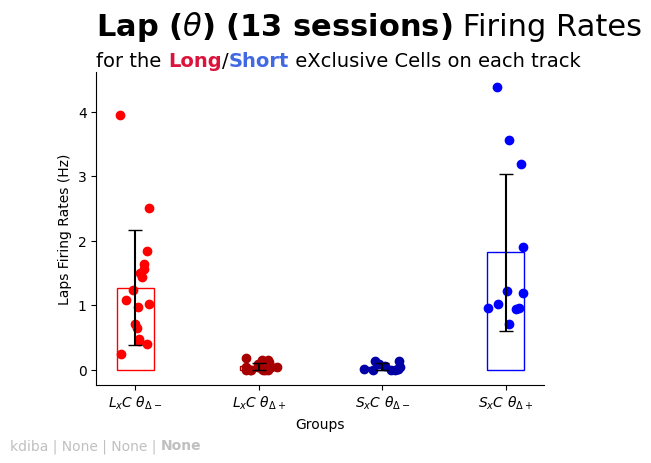

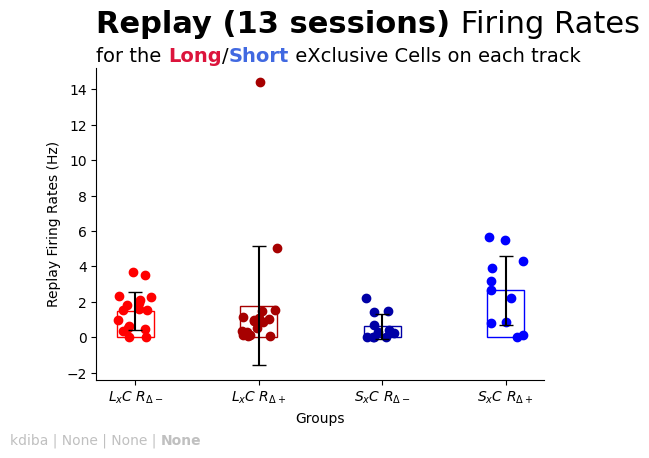

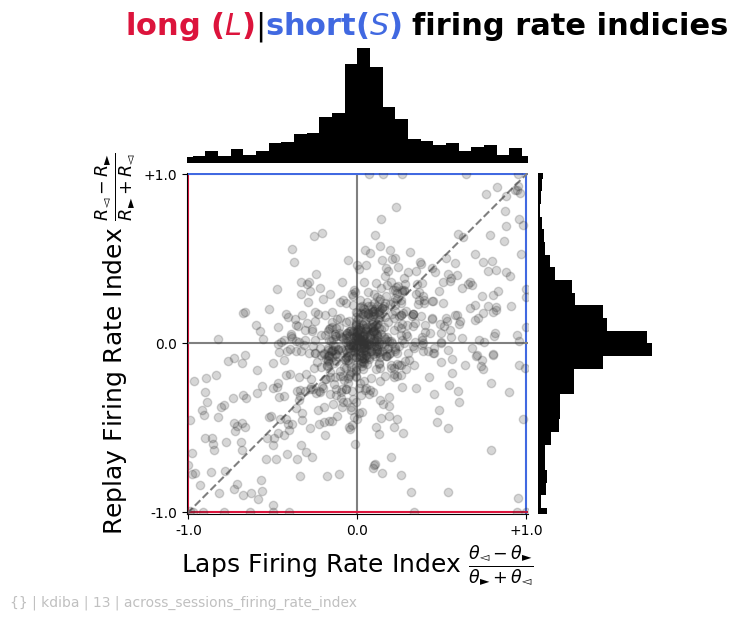

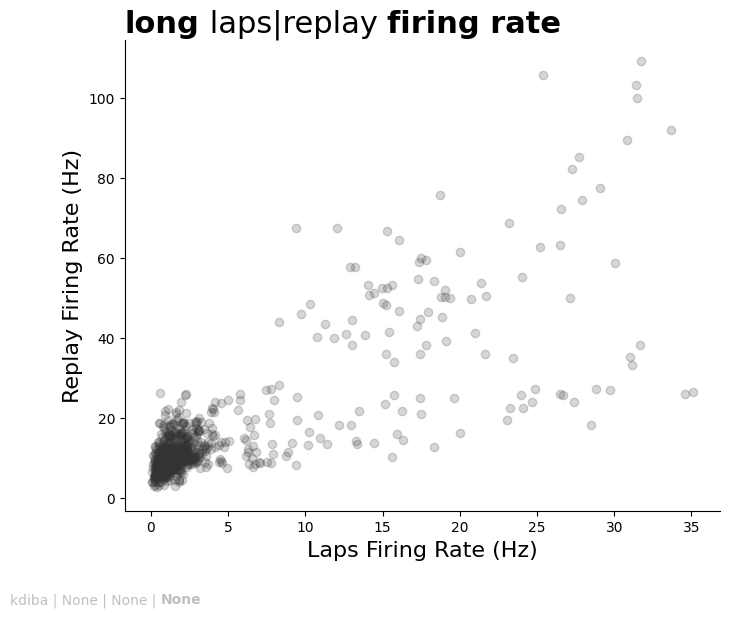

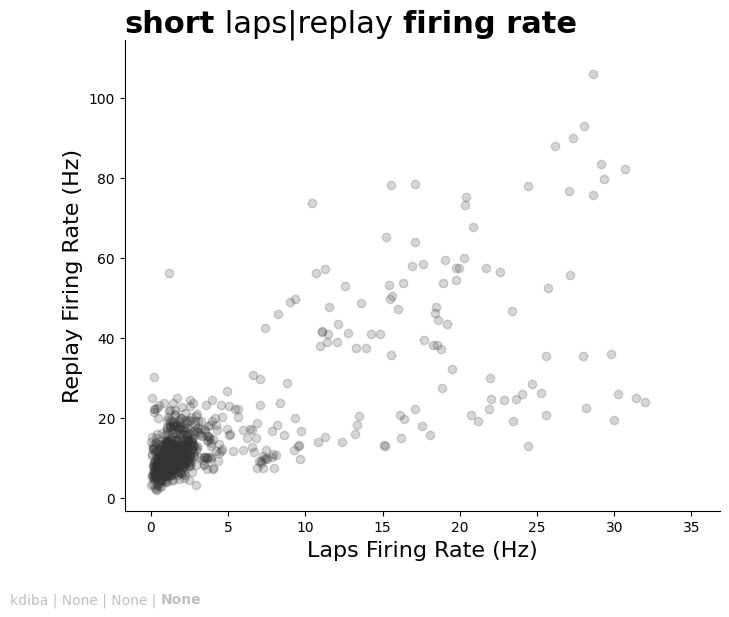

In [32]:
import matplotlib

from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots
from neuropy.utils.matplotlib_helpers import matplotlib_configuration_update
# matplotlib.use('Qt5Agg')
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults, AcrossSessionTables, AcrossSessionsVisualizations

def _save_matplotlib_fig(matplotlib_output_container: MatplotlibRenderPlots):

    a_fig_context = matplotlib_output_container.context
    assert len(matplotlib_output_container.saved_figures) == 1
    a_saved_fig_path = matplotlib_output_container.saved_figures[0][0]
    assert a_saved_fig_path.exists()

    if neptuner_run is not None:
        a_full_figure_path_key: str = a_fig_context.get_description(separator='/', include_property_names=True, key_value_separator=':') # .replace(' ', '_')
        # a_full_figure_path_key: str = a_fig_context.get_description(separator=':', include_property_names=True, key_value_separator='|')
        print(f'a_full_figure_path_key: "{a_full_figure_path_key}"')
        # neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_fig)
        neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_saved_fig_path.as_posix())
        # neptuner.figures[f"{a_full_figure_path_key}"].upload(a_fig)
        

%matplotlib inline


# with matplotlib_configuration_update(is_interactive=False, backend='nbAgg'):
# 'collected_outputs/across_session_result_long_short_recomputed_inst_firing_rate_2024-06-11_GL.pkl'

output_path_suffix: str = '2024-09-12'

# graphics_output_dict = AcrossSessionsResults.post_compute_all_sessions_processing(global_data_root_parent_path=global_data_root_parent_path, BATCH_DATE_TO_USE=BATCH_DATE_TO_USE, plotting_enabled=True)
graphics_output_dict = AcrossSessionsResults.post_compute_all_sessions_processing(global_data_root_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix, plotting_enabled=True, output_override_path=Path('../../output'))

# graphics_output_dict = AcrossSessionsResults.post_compute_all_sessions_processing(global_data_root_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix, plotting_enabled=True, output_override_path=Path('../../output'))

from neuropy.core.user_annotations import UserAnnotationsManager


plotting_enabled = True
global_data_root_parent_path = collected_outputs_directory
output_override_path = Path('../../output')

# 2023-10-04 - Load Saved across-sessions-data and testing Batch-computed inst_firing_rates:
## Load the saved across-session results:
inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}.pkl'
across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=global_data_root_parent_path, inst_fr_output_filename=inst_fr_output_filename)
# across_sessions_instantaneous_fr_dict = loadData(global_batch_result_inst_fr_file_path)
num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

## Load all across-session tables from the pickles:
output_path_suffix: str = f'{output_path_suffix}'
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=global_data_root_parent_path, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp'
num_sessions = len(neuron_replay_stats_table.session_uid.unique().to_numpy())
print(f'num_sessions: {num_sessions}')


In [34]:
long_short_fr_indicies_analysis_table

format_name animal exper_name        session_name  index  \
0         kdiba  gor01        one  2006-6-08_14-26-15      0   
1         kdiba  gor01        one  2006-6-08_14-26-15      1   
2         kdiba  gor01        one  2006-6-08_14-26-15      2   
3         kdiba  gor01        one  2006-6-08_14-26-15      3   
4         kdiba  gor01        one  2006-6-08_14-26-15      4   
..          ...    ...        ...                 ...    ...   
801       kdiba  pin01        one   fet11-01_12-58-54     26   
802       kdiba  pin01        one   fet11-01_12-58-54     27   
803       kdiba  pin01        one   fet11-01_12-58-54     28   
804       kdiba  pin01        one   fet11-01_12-58-54     29   
805       kdiba  pin01        one   fet11-01_12-58-54     30   

                               neuron_uid                         session_uid  \
0    kdiba|gor01|one|2006-6-08_14-26-15|2  kdiba|gor01|one|2006-6-08_14-26-15   
1    kdiba|gor01|one|2006-6-08_14-26-15|3  kdiba|gor01|one|2006-6-08_14-26-15   
2    kdiba|gor01|one|2006-6-08_14-26-15|4  kdiba|gor01|one|2006-6-08_14-26-15   
3    kdiba|gor01|one|2006-6-08_14-26-15|5  kdiba|gor01|one|2006-6-08_14-26-15   
4    kdiba|gor01|one|2006-6-08_14-26-15|6  kdiba|gor01|one|2006-6-08_14-26-15   
..                                    ...                                 ...   
801  kdiba|pin01|one|fet11-01_12-58-54|28   kdiba|pin01|one|fet11-01_12-58-54   
802  kdiba|pin01|one|fet11-01_12-58-54|29   kdiba|pin01|one|fet11-01_12-58-54   
803  kdiba|pin01|one|fet11-01_12-58-54|30   kdiba|pin01|one|fet11-01_12-58-54   
804  kdiba|pin01|one|fet11-01_12-58-54|31   kdiba|pin01|one|fet11-01_12-58-54   
805  kdiba|pin01|one|fet11-01_12-58-54|32   kdiba|pin01|one|fet11-01_12-58-54   

     aclu  x_frs_index  y_frs_index    session_datetime  \
0       2     0.950171     1.000000 2006-06-08 14:26:15   
1       3    -0.852388    -0.593507 2006-06-08 14:26:15   
2       4    -0.971940    -1.000000 2006-06-08 14:26:15   
3       5     0.147308    -0.043639 2006-06-08 14:26:15   
4       6     0.443550     0.445497 2006-06-08 14:26:15   
..    ...          ...          ...                 ...   
801    28    -0.557444     0.026565 2009-11-01 12:58:54   
802    29    -0.294036     0.247180 2009-11-01 12:58:54   
803    30    -0.249504     0.131576 2009-11-01 12:58:54   
804    31     0.256910     0.257815 2009-11-01 12:58:54   
805    32     0.507367     0.363465 2009-11-01 12:58:54   

     session_experience_rank  session_experience_orientation_rank  \
0                          2                                    1   
1                          2                                    1   
2                          2                                    1   
3                          2                                    1   
4                          2                                    1   
..                       ...                                  ...   
801                        0                                    0   
802                        0                                    0   
803                        0                                    0   
804                        0                                    0   
805                        0                                    0   

     is_novel_exposure  
0                False  
1                False  
2                False  
3                False  
4                False  
..                 ...  
801               True  
802               True  
803               True  
804               True  
805               True  

[806 rows x 14 columns]

In [33]:
neuron_identities_table

neuron_uid                         session_uid  \
0    kdiba|gor01|one|2006-6-08_14-26-15|2  kdiba|gor01|one|2006-6-08_14-26-15   
1    kdiba|gor01|one|2006-6-08_14-26-15|3  kdiba|gor01|one|2006-6-08_14-26-15   
2    kdiba|gor01|one|2006-6-08_14-26-15|4  kdiba|gor01|one|2006-6-08_14-26-15   
3    kdiba|gor01|one|2006-6-08_14-26-15|5  kdiba|gor01|one|2006-6-08_14-26-15   
4    kdiba|gor01|one|2006-6-08_14-26-15|6  kdiba|gor01|one|2006-6-08_14-26-15   
..                                    ...                                 ...   
801  kdiba|pin01|one|fet11-01_12-58-54|28   kdiba|pin01|one|fet11-01_12-58-54   
802  kdiba|pin01|one|fet11-01_12-58-54|29   kdiba|pin01|one|fet11-01_12-58-54   
803  kdiba|pin01|one|fet11-01_12-58-54|30   kdiba|pin01|one|fet11-01_12-58-54   
804  kdiba|pin01|one|fet11-01_12-58-54|31   kdiba|pin01|one|fet11-01_12-58-54   
805  kdiba|pin01|one|fet11-01_12-58-54|32   kdiba|pin01|one|fet11-01_12-58-54   

       session_datetime format_name animal exper_name        session_name  \
0   2006-06-08 14:26:15       kdiba  gor01        one  2006-6-08_14-26-15   
1   2006-06-08 14:26:15       kdiba  gor01        one  2006-6-08_14-26-15   
2   2006-06-08 14:26:15       kdiba  gor01        one  2006-6-08_14-26-15   
3   2006-06-08 14:26:15       kdiba  gor01        one  2006-6-08_14-26-15   
4   2006-06-08 14:26:15       kdiba  gor01        one  2006-6-08_14-26-15   
..                  ...         ...    ...        ...                 ...   
801 2009-11-01 12:58:54       kdiba  pin01        one   fet11-01_12-58-54   
802 2009-11-01 12:58:54       kdiba  pin01        one   fet11-01_12-58-54   
803 2009-11-01 12:58:54       kdiba  pin01        one   fet11-01_12-58-54   
804 2009-11-01 12:58:54       kdiba  pin01        one   fet11-01_12-58-54   
805 2009-11-01 12:58:54       kdiba  pin01        one   fet11-01_12-58-54   

     aclu neuron_type  cluster_index  qclu  shank_index  \
0       2         pyr              6     2            1   
1       3         pyr              9     4            1   
2       4         pyr             10     4            1   
3       5         pyr             11     2            1   
4       6        intr             12     5            1   
..    ...         ...            ...   ...          ...   
801    28         pyr             10     2            3   
802    29         pyr             11     2            3   
803    30         pyr             14     2            3   
804    31         pyr              3     4            4   
805    32         pyr              6     2            4   

     session_experience_rank  session_experience_orientation_rank  \
0                          2                                    1   
1                          2                                    1   
2                          2                                    1   
3                          2                                    1   
4                          2                                    1   
..                       ...                                  ...   
801                        0                                    0   
802                        0                                    0   
803                        0                                    0   
804                        0                                    0   
805                        0                                    0   

     is_novel_exposure  
0                False  
1                False  
2                False  
3                False  
4                False  
..                 ...  
801               True  
802               True  
803               True  
804               True  
805               True  

[806 rows x 15 columns]

In [ ]:

## group by 'is_novel_exposure'


# ['is_novel_exposure']

# partition_df(neuron_replay_stats_table, partitionColumn='is_novel_exposure')

is_novel_partitioned_dfs = dict(zip(*partition_df(neuron_replay_stats_table, partitionColumn='is_novel_exposure')))
novel_session_uids = is_novel_partitioned_dfs[True]['session_uid'].unique().tolist()
non_novel_session_uids = is_novel_partitioned_dfs[False]['session_uid'].unique().tolist()

novel_session_uids



In [ ]:


# # Does its own additions to `long_short_fr_indicies_analysis_table` table based on the user labeled LxC/SxCs
# annotation_man = UserAnnotationsManager()
# # Hardcoded included_session_contexts:
# included_session_contexts = annotation_man.get_hardcoded_good_sessions()

# if output_override_path is None:
#     output_override_path = Path('output').resolve()
#     output_override_path.mkdir(parents=True, exist_ok=True)
    

# LxC_uids = []
# SxC_uids = []

# for a_ctxt in included_session_contexts:
#     session_uid = a_ctxt.get_description(separator="|", include_property_names=False)
#     session_cell_exclusivity: SessionCellExclusivityRecord = annotation_man.annotations[a_ctxt].get('session_cell_exclusivity', None)
#     LxC_uids.extend([f"{session_uid}|{aclu}" for aclu in session_cell_exclusivity.LxC])
#     SxC_uids.extend([f"{session_uid}|{aclu}" for aclu in session_cell_exclusivity.SxC])

# # [a_ctxt.get_description(separator="|", include_property_names=False) for a_ctxt in included_session_contexts]

# long_short_fr_indicies_analysis_table['XxC_status'] = 'Shared'
# long_short_fr_indicies_analysis_table.loc[np.isin(long_short_fr_indicies_analysis_table.neuron_uid, LxC_uids), 'XxC_status'] = 'LxC'
# long_short_fr_indicies_analysis_table.loc[np.isin(long_short_fr_indicies_analysis_table.neuron_uid, SxC_uids), 'XxC_status'] = 'SxC'

# ## 2023-10-11 - Get the long peak location
# long_short_fr_indicies_analysis_table['long_pf_peak_x'] = neuron_replay_stats_table['long_pf_peak_x']
# # long_short_fr_indicies_analysis_table

# # long_short_fr_indicies_analysis_table_filename = 'output/2023-10-07_long_short_fr_indicies_analysis_table.csv'
# long_short_fr_indicies_analysis_table_filename: Path = output_override_path.joinpath(f'{output_path_suffix}_long_short_fr_indicies_analysis_table.csv')
# long_short_fr_indicies_analysis_table.to_csv(long_short_fr_indicies_analysis_table_filename)
# print(f'saved: {long_short_fr_indicies_analysis_table_filename}')



# # 2023-10-10 - Statistics for `across_sessions_bar_graphs`, analysing `across_session_inst_fr_computation`
# binom_test_chance_result = pho_stats_perform_diagonal_line_binomial_test(long_short_fr_indicies_analysis_table)
# print(f'binom_test_chance_result: {binom_test_chance_result}')

# LxC_Laps_T_result, SxC_Laps_T_result, LxC_Replay_T_result, SxC_Replay_T_result = pho_stats_bar_graph_t_tests(across_session_inst_fr_computation)

# _out = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

# %matplotlib inline 
%matplotlib qt5
## Plotting:
graphics_output_dict = {}

# matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

# long_short_fr_indicies_analysis_table.plot.scatter(x='long_pf_peak_x', y='x_frs_index', title='Pf Peak position vs. LapsFRI', ylabel='Lap FRI')
# long_short_fr_indicies_analysis_table.plot.scatter(x='long_pf_peak_x', y='y_frs_index', title='Pf Peak position vs. ReplayFRI', ylabel='Replay FRI')

## 2023-10-04 - Run `AcrossSessionsVisualizations` corresponding to the PhoDibaPaper2023 figures for all sessions
## Hacks the `PaperFigureTwo` and `InstantaneousSpikeRateGroupsComputation`
global_multi_session_context, _out_aggregate_fig_2 = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation, num_sessions=num_sessions, enable_tiny_point_labels=True, enable_hover_labels=False, save_figure=False)
# plt.show()

In [ ]:
# across_session_inst_fr_computation
## Document `InstantaneousSpikeRateGroupsComputation`
from pyphocorehelpers.print_helpers import DocumentationFilePrinter
from pyphocorehelpers.print_helpers import print_keys_if_possible

doc_output_parent_folder = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\DEVELOPER_NOTES\DataStructureDocumentation').resolve()
Assert.path_exists(doc_output_parent_folder)
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=doc_output_parent_folder, doc_name='InstantaneousSpikeRateGroupsComputation')
doc_printer.save_documentation('InstantaneousSpikeRateGroupsComputation', across_session_inst_fr_computation, non_expanded_item_keys=['_reverse_cellID_index_map'])

In [ ]:
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=doc_output_parent_folder, doc_name='SingleBarResult')
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[0], non_expanded_item_keys=['_reverse_cellID_index_map'])
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[1], non_expanded_item_keys=['_reverse_cellID_index_map'])
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[2], non_expanded_item_keys=['_reverse_cellID_index_map'])
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[3], non_expanded_item_keys=['_reverse_cellID_index_map'])

In [ ]:
across_session_inst_fr_computation.get_summary_dataframe()

In [ ]:
across_sessions_instantaneous_frs_list


In [ ]:
# print_keys_if_possible('InstantaneousSpikeRateGroupsComputation', across_session_inst_fr_computation, max_depth=3)



# 2024-09-10 - TODO: Filter out the datapoints from the bar plot corresponding to the novel vs. non-novel sessions

In [ ]:
import re
from typing import List, Tuple

def parse_concise_abbreviated_neuron_identifying_strings(data: List[str]) -> List[Tuple[int, int, int]]:
    """ parses ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27'] into ( animal_idx, session_idx, and aclu)
    """
    parsed_data = []
    for entry in data:
        match = re.match(r'a(\d+)s(\d+)_(\d+)', entry)
        if match:
            animal_idx, session_idx, aclu = map(int, match.groups())
            parsed_data.append((animal_idx, session_idx, aclu))
        else:
            raise ValueError(f"String format not recognized: {entry}")
    
    parsed_aclus_df = pd.DataFrame(parsed_data, columns=['animal_idx', 'session_idx', 'aclu'])
    parsed_aclus_df['is_session_novel'] = (parsed_aclus_df['session_idx'] < 2)
    return parsed_aclus_df


# `across_session_inst_fr_computation.Fig2_Replay_FR`

novel_Fig2_Replay_FR = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR)
non_novel_Fig2_Replay_FR = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR)


# [0] and [1] both only use LxC_aclus
LxC_aclus = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[0].LxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
_LxC_aclus_alt = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[1].LxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
assert _LxC_aclus_alt == LxC_aclus

# [2] and [3] both only use SxC_aclus
SxC_aclus = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[2].SxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
_SxC_aclus_alt = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[3].SxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
assert _SxC_aclus_alt == SxC_aclus

parsed_LxC_aclus_df: pd.DataFrame = parse_concise_abbreviated_neuron_identifying_strings(LxC_aclus)
# parsed_LxC_aclus_df

parsed_SxC_aclus_df: pd.DataFrame = parse_concise_abbreviated_neuron_identifying_strings(SxC_aclus)
# parsed_SxC_aclus_df

# novel_LxC_indicies, non_novel_LxC_indicies = 
# partition_df(parsed_LxC_aclus_df, partitionColumn='is_session_novel')
# partition_df(parsed_SxC_aclus_df, partitionColumn='is_session_novel')

novel_LxC_indicies = np.where(parsed_LxC_aclus_df['is_session_novel'])[0]
non_novel_LxC_indicies = np.where(np.logical_not(parsed_LxC_aclus_df['is_session_novel']))[0]

(novel_LxC_indicies, non_novel_LxC_indicies)

novel_SxC_indicies = np.where(parsed_SxC_aclus_df['is_session_novel'])[0]
non_novel_SxC_indicies = np.where(np.logical_not(parsed_SxC_aclus_df['is_session_novel']))[0]

(novel_SxC_indicies, non_novel_SxC_indicies)

## OUTPUTS: (novel_LxC_indicies, non_novel_LxC_indicies), (novel_SxC_indicies, non_novel_SxC_indicies)

In [ ]:
curr_idx: int = 0
novel_Fig2_Replay_FR[curr_idx].LxC_aclus = novel_Fig2_Replay_FR[curr_idx].LxC_aclus[novel_LxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_LxC_indicies]
# [np.array(novel_Fig2_Replay_FR[0].LxC_scatter_props)[i] for i in novel_LxC_indicies] # not sure how to reduce these
# novel_Fig2_Replay_FR[0].LxC_scatter_props = [np.array(novel_Fig2_Replay_FR[0].LxC_scatter_props)[i] for i in novel_LxC_indicies] # not sure how to reduce these
# len(novel_Fig2_Replay_FR[0].LxC_scatter_props)
# novel_Fig2_Replay_FR[curr_idx].LxC_scatter_props # [novel_LxC_indicies]

# for i in novel_LxC_indicies:
#     print(i)
#     novel_Fig2_Replay_FR[curr_idx].LxC_scatter_props[i] = {'marker': '*'} # [novel_LxC_indicies]


curr_idx: int = 1
novel_Fig2_Replay_FR[curr_idx].LxC_aclus = novel_Fig2_Replay_FR[curr_idx].LxC_aclus[novel_LxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_LxC_indicies]
curr_idx: int = 2
novel_Fig2_Replay_FR[curr_idx].SxC_aclus = novel_Fig2_Replay_FR[curr_idx].SxC_aclus[novel_SxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_SxC_indicies]
curr_idx: int = 3
novel_Fig2_Replay_FR[curr_idx].SxC_aclus = novel_Fig2_Replay_FR[curr_idx].SxC_aclus[novel_SxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_SxC_indicies]

across_session_inst_fr_computation.Fig2_Replay_FR = novel_Fig2_Replay_FR

In [ ]:
global_multi_session_context, _out_aggregate_fig_2 = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation, num_sessions=num_sessions, enable_tiny_point_labels=True, enable_hover_labels=False, save_figure=False)

In [ ]:
plt.close('all')

In [ ]:


## for `long_short_fr_indicies_analysis_table`
is_novel_partitioned_dfs = dict(zip(*partition_df(long_short_fr_indicies_analysis_table, partitionColumn='is_novel_exposure')))
novel_session_uids = is_novel_partitioned_dfs[True]['session_uid'].unique().tolist()
non_novel_session_uids = is_novel_partitioned_dfs[False]['session_uid'].unique().tolist()

novel_session_uids



In [ ]:

# across_sessions_instantaneous_fr_dict

novel_only_inst_fr_dict = {k:v for k, v in across_sessions_instantaneous_fr_dict.items() if k.get_description(separator='|') in novel_session_uids}
non_novel_inst_fr_dict = {k:v for k, v in across_sessions_instantaneous_fr_dict.items() if k.get_description(separator='|') not in novel_session_uids}
novel_only_inst_fr_dict

In [ ]:
# all
# graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=False)
# split based on session novelty:
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=is_novel_partitioned_dfs[True], num_sessions=len(novel_session_uids), save_figure=False)
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=is_novel_partitioned_dfs[False], num_sessions=len(non_novel_session_uids), save_figure=False)


In [ ]:
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_long_and_short_firing_rate_replays_v_laps_figure(neuron_replay_stats_table=neuron_replay_stats_table, num_sessions=num_sessions, save_figure=True)


In [ ]:
## Aggregate across all of the sessions to build a new combined `InstantaneousSpikeRateGroupsComputation`, which can be used to plot the "PaperFigureTwo", bar plots for many sessions.
global_multi_session_context = IdentifyingContext(format_name='kdiba', num_sessions=num_sessions) # some global context across all of the sessions, not sure what to put here.



In [ ]:
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=False, backend='AGG')

plt.show()


In [ ]:
plt.close('all')    

In [ ]:

matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
matplotlib_output_container: MatplotlibRenderPlots = AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=False)

# graphics_output_dict.figures[0]
# graphics_output_dict.context
# _save_matplotlib_fig(matplotlib_output_container)



# matplotlib.use('nbAgg')



In [ ]:
plt.close('all')

In [ ]:
graphics_output_dict.saved_figures[0][0] #.plot_data['saved_figures']

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard

fig_to_clipboard(fig)


In [ ]:
# copy_image_to_clipboard(graphics_output_dict['figures'][0])
fig_to_clipboard(matplotlib_output_container.figures[0])

In [ ]:
matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
graphics_output_dict = AcrossSessionsVisualizations.across_sessions_long_and_short_firing_rate_replays_v_laps_figure(neuron_replay_stats_table=neuron_replay_stats_table, num_sessions=num_sessions)

In [ ]:
_save_matplotlib_fig(graphics_output_dict)


In [ ]:
## Load the saved across-session results:
# Outputs: across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list, neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table

BATCH_DATE_TO_USE = f'2024-09-03'
inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{BATCH_DATE_TO_USE}.pkl'

inst_fr_output_file = collected_outputs_directory.joinpath(inst_fr_output_filename).resolve()
Assert.path_exists(inst_fr_output_file)

across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=collected_outputs_directory, inst_fr_output_filename=inst_fr_output_filename)
# across_sessions_instantaneous_fr_dict = loadData(global_batch_result_inst_fr_file_path)
num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import 

## Load all across-session tables from the pickles:
output_path_suffix: str = f'{BATCH_DATE_TO_USE}'
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp'
num_sessions = len(neuron_replay_stats_table.session_uid.unique().to_numpy())
print(f'num_sessions: {num_sessions}')
# neuron_replay_stats_table


In [ ]:
neptuner.stop()

## 2024-09-04 - Batch Output Files

In [ ]:
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.Filesystem.metadata_helpers import FilesystemMetadata, get_file_metadata
from pyphocorehelpers.Filesystem.path_helpers import discover_data_files, generate_copydict, copy_movedict, copy_file, save_copydict_to_text_file, read_copydict_from_text_file, invert_filedict
from pyphoplacecellanalysis.General.Batch.runBatch import get_file_str_if_file_exists
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import check_output_h5_files, copy_files_in_filelist_to_dest
from pyphoplacecellanalysis.General.Batch.runBatch import ConcreteSessionFolder, BackupMethods

# a_batch_progress_df = included_session_batch_progress_df.copy()
included_session_contexts
h5_contexts_paths_dict
# h5_session_contexts

debug_print = False
known_global_data_root_parent_paths = [Path(r'/nfs/turbo/umms-kdiba/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/media/halechr/MAX/Data'), Path(r'/Volumes/MoverNew/data')] # , Path(r'/home/halechr/FastData'), Path(r'/home/halechr/turbo/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data')
global_data_root_parent_path = find_first_extant_path(known_global_data_root_parent_paths)
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
## Build Pickle Path:
# Hardcoded included_session_contexts:
included_session_contexts = UserAnnotationsManager.get_hardcoded_good_sessions()
good_session_concrete_folders = ConcreteSessionFolder.build_concrete_session_folders(global_data_root_parent_path, included_session_contexts)

# Output Paths:
included_h5_paths = [get_file_str_if_file_exists(v.pipeline_results_h5) for v in good_session_concrete_folders]
# copy_dict = ConcreteSessionFolder.build_backup_copydict(good_session_concrete_folders, backup_mode=BackupMethods.RenameInSourceDirectory, only_include_file_types=['local_pkl', 'global_pkl'])
check_output_h5_files(included_h5_paths)

## OUTPUTS: included_h5_paths, included_session_contexts, good_session_concrete_folders

included_h5_paths


RESULT_DATE_TO_USE = '2024-09-04'
# RESULT_DATE_TO_USE = '2024-07-02'

# included_file_types_paths_dict = {'h5': included_h5_paths, 'recomputed_inst_fr_comps': []}
# included_file_types_paths_dict['recomputed_inst_fr_comps'] = [get_file_path_if_file_exists(v.output_folder.joinpath(f'{RESULT_DATE_TO_USE}_recomputed_inst_fr_comps_0.0005.h5').resolve()) for v in good_session_concrete_folders]
# included_file_types_paths_dict


In [ ]:
## INPUTS: good_session_concrete_folders, target_dir, BATCH_DATE_TO_USE, custom_file_types_dict
from pyphoplacecellanalysis.General.Batch.runBatch import get_file_path_if_file_exists
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import copy_session_folder_files_to_target_dir

custom_file_types_dict = {'recomputed_inst_fr_comps': (lambda a_session_folder: get_file_path_if_file_exists(a_session_folder.output_folder.joinpath(f'{RESULT_DATE_TO_USE}_recomputed_inst_fr_comps_0.0005.pkl').resolve())),
						#   'PHONEW.evt': (lambda a_session_folder: get_file_path_if_file_exists(a_session_folder.output_folder.joinpath(f'{a_session_folder.context.session_name}.PHONEW.evt').resolve())),
						  }

# target_dir: Path = Path(global_data_root_parent_path)
target_dir: Path = collected_outputs_directory
moved_files_dict_files, (filelist_path, filedict_out_path) = copy_session_folder_files_to_target_dir(good_session_concrete_folders, target_dir=target_dir, RESULT_DATE_TO_USE=BATCH_DATE_TO_USE, custom_file_types_dict=custom_file_types_dict, dry_run=False)

In [ ]:

read_moved_files_dict_files = read_copydict_from_text_file(filedict_out_path, debug_print=False)
read_moved_files_dict_files
# read_moved_files_dict_files
restore_moved_files_dict_files = invert_filedict(read_moved_files_dict_files)
restore_moved_files_dict_files

## Extract `across_sessions_instantaneous_fr_dict` from the computation outputs

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import loadData

across_sessions_recomputed_instantaneous_fr_dict = {}

for a_session_folder in good_session_concrete_folders:
    
    curr_pkl = custom_file_types_dict['recomputed_inst_fr_comps'](a_session_folder)
    if curr_pkl is not None and (curr_pkl.exists()):
        assert curr_pkl.exists()
        print(a_session_folder)
        print(curr_pkl)
        across_sessions_recomputed_instantaneous_fr_dict[a_session_folder.context] = loadData(curr_pkl) # InstantaneousSpikeRateGroupsComputation

# OUTPUT:  across_sessions_recomputed_instantaneous_fr_dict
num_sessions = len(across_sessions_recomputed_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

## Outputs: across_sessions_instantaneous_fr_dict, across_sessions_recomputed_instantaneous_fr_dict
across_session_result_long_short_recomputed_inst_firing_rate_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{BATCH_DATE_TO_USE}.pkl'
AcrossSessionsResults.save_across_sessions_data(across_sessions_instantaneous_fr_dict=across_sessions_recomputed_instantaneous_fr_dict, global_data_root_parent_path=collected_outputs_directory.resolve(),
                                                 inst_fr_output_filename=across_session_result_long_short_recomputed_inst_firing_rate_filename)


In [ ]:
desired_shared_decoding_time_bin_sizes = np.linspace(start=0.030, stop=0.10, num=6) ####### <<<------ Default sweep is defined here

for an_instantaneous_time_bin_size_seconds in desired_shared_decoding_time_bin_sizes:
    # an_instantaneous_time_bin_size_seconds = 0.0005

    self.compute_and_export_session_instantaneous_spike_rates_completion_function(global_data_root_parent_path=global_data_root_parent_path, curr_session_context=curr_session_context, curr_session_basedir=curr_session_basedir, curr_active_pipeline=curr_active_pipeline, across_session_results_extended_dict=across_session_results_extended_dict, instantaneous_time_bin_size_seconds=an_instantaneous_time_bin_size_seconds,
                                                                        save_hdf=True, save_pickle=True, save_across_session_hdf=False)

        